In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tabulate import tabulate
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from matplotlib import pyplot as plt

import copy
import csv

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'cat', 'deer', 'dog'}
fg_used = '345'
fg1, fg2, fg3 = 3,4,5


all_classes = {'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}
background_classes = all_classes - foreground_classes
background_classes

# print(type(foreground_classes))

In [0]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)
    

In [0]:
def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

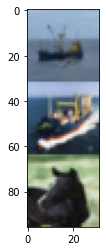

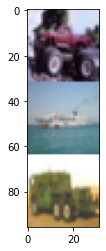

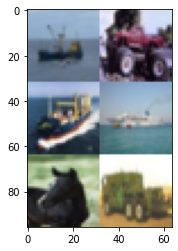

torch.Size([3, 96, 32])


In [0]:
img1 = torch.cat((background_data[0],background_data[1],background_data[2]),1)
imshow(img1)
img2 = torch.cat((background_data[27],background_data[3],background_data[43]),1)
imshow(img2)
img3 = torch.cat((img1,img2),2)
imshow(img3)
print(img2.size())


In [0]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]].type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx].type("torch.DoubleTensor"))
      label = foreground_label[fg_idx] - fg1  # minus fg1 because our fore ground classes are fg1,fg2,fg3 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [0]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
list_set_labels = [] 
for i in range(desired_num):
  set_idx = set()
  bg_idx = np.random.randint(0,35000,8)
  set_idx = set(background_label[bg_idx].tolist())
  fg_idx = np.random.randint(0,15000)
  set_idx.add(foreground_label[fg_idx].item())
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)
  list_set_labels.append(set_idx)


2


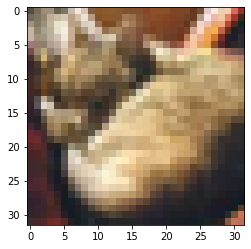

plane


In [0]:
qw=45

print(fore_idx[qw])
imshow(mosaic_list_of_images[qw][fore_idx[qw]])
# print(mosaic_list_of_images[0])
print(classes[mosaic_label[qw]]) 

# imshow(mosaic_list_of_images[13][2])
# print(type(mosaic_list_of_images[1][0]))
# print(mosaic_label)

In [0]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [0]:
class Module1(nn.Module):
  def __init__(self):
    super(Module1, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,1)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [0]:
class Module2(nn.Module):
  def __init__(self):
    super(Module2, self).__init__()
    self.module1 = Module1().double()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,3)

  def forward(self,z):  #z batch of list of 9 images
    y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
    x = torch.zeros([batch,9],dtype=torch.float64)
    x = x.to("cuda")
    y = y.to("cuda")
    for i in range(9):
        x[:,i] = self.module1.forward(z[:,i])[:,0]

    x = F.softmax(x,dim=1)

    x1 = x[:,0]
    torch.mul(x1[:,None,None,None],z[:,0])

    for i in range(9):            
      x1 = x[:,i]          
      y = y + torch.mul(x1[:,None,None,None],z[:,i])
      y = y.contiguous()


    y1 = self.pool(F.relu(self.conv1(y)))
    y1 = self.pool(F.relu(self.conv2(y1)))
    y1 = y1.contiguous()
    y1 = y1.reshape(-1, 16 * 5 * 5)

    y1 = F.relu(self.fc1(y1))
    y1 = F.relu(self.fc2(y1))
    y1 = F.relu(self.fc3(y1))
    y1 = self.fc4(y1)
    return y1 , x, y

In [0]:
fore_net = Module2().double()
fore_net = fore_net.to("cuda")

In [0]:
fore_net.load_state_dict(torch.load("/content/drive/My Drive/Research/drill_deep_cifar/weights/fore_net_epoch142_fg_used345.pt"))

<All keys matched successfully>

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(fore_net.parameters(), lr=0.01, momentum=0.9)
nos_epochs = 600

for epoch in range(nos_epochs):  # loop over the dataset multiple times

  running_loss = 0.0
  cnt=0
  mini_loss = []

  iteration = desired_num // batch

  for i, data in  enumerate(train_loader):
    inputs , labels , fore_idx = data
    inputs, labels, fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")

    optimizer.zero_grad()
    
    outputs, alphas, avg_images = fore_net(inputs)

    _, predicted = torch.max(outputs.data, 1)


    loss = criterion(outputs, labels) 
    loss.backward()

    optimizer.step()
    running_loss += loss.item()
    mini = 40
  
    if cnt % mini == mini - 1:    # print every 40 mini-batches
      print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / mini))
      mini_loss.append(running_loss / mini)
      running_loss = 0.0
      
    cnt=cnt+1
  if(np.average(mini_loss) <= 0.05):
    break
print('Finished Training')
# torch.save(what_net.state_dict(),"/content/drive/My Drive/Research/drill_deep_cifar/weights/model_epoch"+str(nos_epochs)+".pt")
# torch.save(what_net.state_dict(),"/content/drive/My Drive/Research/drill_deep_cifar/weights/model_epoch"+str(nos_epochs)+".pt")

[1,    40] loss: 1.174
[1,    80] loss: 0.825
[1,   120] loss: 0.776
[2,    40] loss: 0.703
[2,    80] loss: 0.706
[2,   120] loss: 0.696
[3,    40] loss: 0.634
[3,    80] loss: 0.625
[3,   120] loss: 0.653
[4,    40] loss: 0.587
[4,    80] loss: 0.590
[4,   120] loss: 0.634
[5,    40] loss: 0.572
[5,    80] loss: 0.583
[5,   120] loss: 0.571
[6,    40] loss: 0.545
[6,    80] loss: 0.596
[6,   120] loss: 0.563
[7,    40] loss: 0.528
[7,    80] loss: 0.533
[7,   120] loss: 0.579
[8,    40] loss: 0.529
[8,    80] loss: 0.563
[8,   120] loss: 0.572
[9,    40] loss: 0.523
[9,    80] loss: 0.527
[9,   120] loss: 0.535
[10,    40] loss: 0.501
[10,    80] loss: 0.499
[10,   120] loss: 0.518
[11,    40] loss: 0.488
[11,    80] loss: 0.509
[11,   120] loss: 0.514
[12,    40] loss: 0.472
[12,    80] loss: 0.488
[12,   120] loss: 0.489
[13,    40] loss: 0.490
[13,    80] loss: 0.489
[13,   120] loss: 0.493
[14,    40] loss: 0.431
[14,    80] loss: 0.477
[14,   120] loss: 0.475
[15,    40] loss: 0

In [0]:
# torch.save(fore_net.state_dict(),"/content/drive/My Drive/Research/drill_deep_cifar/weights/fore_net_epoch"+str(epoch)+"_fg_used"+str(fg_used)+".pt")

In [0]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
test_set_labels = []
for i in range(10000):
  set_idx = set()
  bg_idx = np.random.randint(0,35000,8)
  set_idx = set(background_label[bg_idx].tolist())
  fg_idx = np.random.randint(0,15000)
  set_idx.add(foreground_label[fg_idx].item())
  fg = np.random.randint(0,9)
  fore_idx_test.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  test_images.append(image_list)
  test_label.append(label)
  test_set_labels.append(set_idx)


In [0]:
test_data = MosaicDataset(test_images,test_label,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [0]:
torch.argmax(alphas[5]), alphas[5]

(tensor(5, device='cuda:0', grad_fn=<NotImplemented>),
 tensor([0.0609, 0.1168, 0.0210, 0.0879, 0.1914, 0.4285, 0.0022, 0.0585, 0.0327],
        device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward>))

In [0]:
test_set = DataLoader( test_data,batch_size= batch ,shuffle=False)
train_set = DataLoader( msd,batch_size= batch ,shuffle=False)

#TRAIN SUMMARY

In [0]:
fg = [fg1, fg2, fg3]
all_list = [0,1,2,3,4,5,6,7,8,9]
bg = list(set(all_list)-set(fg))
fg, bg

([3, 4, 5], [0, 1, 2, 6, 7, 8, 9])

In [0]:
from tabulate import tabulate
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in train_set:
    inputs, labels , fore_idx = data
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    outputs, alphas, avg_images = fore_net(inputs)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      count += 1
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)
print(count)

print("="*100)
table3 = []
entry = [1,'fg = '+ str(fg),'bg = '+str(bg),30000]
entry.append((100 * focus_true_pred_true / total))
entry.append( (100 * focus_false_pred_true / total))
entry.append( ( 100 * focus_true_pred_false / total))
entry.append( ( 100 * focus_false_pred_false / total))
entry.append( argmax_more_than_half)

train_entry = entry

table3.append(entry)

print(tabulate(table3, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT', 'FFPT', 'FTPF', 'FFPF', 'avg_img > 0.5'] ) )


Accuracy of the network on the 30000 train images: 98 %
total correct 29593
total train set images 30000
focus_true_pred_true 21265 =============> FTPT : 70 %
focus_false_pred_true 8328 =============> FFPT : 27 %
focus_true_pred_false 63 =============> FTPF : 0 %
focus_false_pred_false 344 =============> FFPF : 1 %
argmax_more_than_half 24688
argmax_less_than_half 5312
30000
  S.No.  fg_class        bg_class                      data_points     FTPT    FFPT    FTPF     FFPF    avg_img > 0.5
-------  --------------  --------------------------  -------------  -------  ------  ------  -------  ---------------
      1  fg = [3, 4, 5]  bg = [0, 1, 2, 6, 7, 8, 9]          30000  70.8833   27.76    0.21  1.14667            24688


#TEST SUMMARY

In [0]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_set:
    inputs, labels , fore_idx = data
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    outputs, alphas, avg_images = fore_net(inputs)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

print("="*100)
table4 = []
entry = [1,'fg = '+ str(fg),'bg = '+str(bg),10000]
entry.append((100 * focus_true_pred_true / total))
entry.append( (100 * focus_false_pred_true / total))
entry.append( ( 100 * focus_true_pred_false / total))
entry.append( ( 100 * focus_false_pred_false / total))
entry.append( argmax_more_than_half)

test_entry = entry 

table4.append(entry)

print(tabulate(table4, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT', 'FFPT', 'FTPF', 'FFPF', 'avg_img > 0.5'] ) )


Accuracy of the network on the 10000 test images: 73 %
total correct 7350
total train set images 10000
focus_true_pred_true 6043 =============> FTPT : 60 %
focus_false_pred_true 1307 =============> FFPT : 13 %
focus_true_pred_false 700 =============> FTPF : 7 %
focus_false_pred_false 1950 =============> FFPF : 19 %
argmax_more_than_half 7889
argmax_less_than_half 2111
  S.No.  fg_class        bg_class                      data_points    FTPT    FFPT    FTPF    FFPF    avg_img > 0.5
-------  --------------  --------------------------  -------------  ------  ------  ------  ------  ---------------
      1  fg = [3, 4, 5]  bg = [0, 1, 2, 6, 7, 8, 9]          10000   60.43   13.07       7    19.5             7889


#Lets see the % of FTPT, FFPT, FTPF, FFPF for FG classes separetly

In [0]:
from tabulate import tabulate
table1 = []
table1.append(train_entry)
entry_no = 2


# cnt=0
for a in fg :
  count = 0
  correct = 0
  total = 0
  focus_true_pred_true = 0
  focus_false_pred_true = 0
  focus_true_pred_false = 0
  focus_false_pred_false = 0
  argmax_more_than_half = 0
  argmax_less_than_half = 0
  with torch.no_grad():
    for data in train_set:
      inputs, labels , fore_idx = data
      inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
      outputs, alphas, avg_images = fore_net(inputs)

      _, predicted = torch.max(outputs.data, 1)

      for m in range(labels.size(0)):
        # count
        if(count == 30000):
          break
        s = list_set_labels[count]
        # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
        if (a in s ):
          # print(str(a)+str(b1)+str(b2)+str(b3))
          total += 1
          focus = torch.argmax(alphas[m])
          if alphas[m][focus] >= 0.5 :
            argmax_more_than_half += 1
          else:
            argmax_less_than_half += 1

          if(focus == fore_idx[m] and predicted[m] == labels[m]):
              focus_true_pred_true += 1
          elif(focus != fore_idx[m] and predicted[m] == labels[m]):
            focus_false_pred_true += 1
          elif(focus == fore_idx[m] and predicted[m] != labels[m]):
            focus_true_pred_false += 1
          elif(focus != fore_idx[m] and predicted[m] != labels[m]):
            focus_false_pred_false += 1
        
        count += 1
      
    correct += (predicted == labels).sum().item()  
    entry = [entry_no,'fg = '+str(a) , 'bg = all_except_fg', total]
    if total == 0:
      entry.append(0)
      entry.append(0)
      entry.append(0)
      entry.append(0)
    else:
      entry.append((100 * focus_true_pred_true / total))
      entry.append( (100 * focus_false_pred_true / total))
      entry.append( ( 100 * focus_true_pred_false / total))
      entry.append( ( 100 * focus_false_pred_false / total))
    entry.append( argmax_more_than_half)
    table1.append(entry)
    entry_no += 1

print("="*20+"Training DATA"+"="*20)
print(tabulate(table1, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Training DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [3, 4, 5]  bg = [0, 1, 2, 6, 7, 8, 9]          30000    70.8833    27.76     0.21       1.14667             24688
      2  fg = 3          bg = all_except_fg                   9933    69.3043    29.7493   0.100675   0.845666             8149
      3  fg = 4          bg = all_except_fg                  10095    60.0792    38.3457   0.277365   1.29767              7480
      4  fg = 5          bg = all_except_fg                   9972    83.3935    15.0622   0.250702   1.29362              9059


In [0]:
# for testing_set
table2 = []
table2.append(test_entry)
entry_no = 2

# cnt=0
for a in fg :
  count = 0
  correct = 0
  total = 0
  focus_true_pred_true = 0
  focus_false_pred_true = 0
  focus_true_pred_false = 0
  focus_false_pred_false = 0
  argmax_more_than_half = 0
  argmax_less_than_half = 0
  with torch.no_grad():
    for data in test_set:
      inputs, labels , fore_idx = data
      inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
      outputs, alphas, avg_images = fore_net(inputs)

      _, predicted = torch.max(outputs.data, 1)

      for m in range(labels.size(0)):
        # count
        if(count == 10000):
          break
        s = list_set_labels[count]
        # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
        if (a in s ):
          # print(str(a)+str(b1)+str(b2)+str(b3))
          total += 1
          focus = torch.argmax(alphas[m])
          if alphas[m][focus] >= 0.5 :
            argmax_more_than_half += 1
          else:
            argmax_less_than_half += 1

          if(focus == fore_idx[m] and predicted[m] == labels[m]):
              focus_true_pred_true += 1
          elif(focus != fore_idx[m] and predicted[m] == labels[m]):
            focus_false_pred_true += 1
          elif(focus == fore_idx[m] and predicted[m] != labels[m]):
            focus_true_pred_false += 1
          elif(focus != fore_idx[m] and predicted[m] != labels[m]):
            focus_false_pred_false += 1
        
        count += 1
      
    correct += (predicted == labels).sum().item()  
    entry = [entry_no,'fg = '+str(a) , 'bg = all_except_fg', total]
    if total == 0:
      entry.append(0)
      entry.append(0)
      entry.append(0)
      entry.append(0)
    else:
      entry.append((100 * focus_true_pred_true / total))
      entry.append( (100 * focus_false_pred_true / total))
      entry.append( ( 100 * focus_true_pred_false / total))
      entry.append( ( 100 * focus_false_pred_false / total))
    entry.append( argmax_more_than_half)
    table2.append(entry)
    entry_no += 1

print("="*20+"Testing DATA"+"="*20)
print(tabulate(table2, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Testing DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [3, 4, 5]  bg = [0, 1, 2, 6, 7, 8, 9]          10000    60.43      13.07      7          19.5                7889
      2  fg = 3          bg = all_except_fg                   3372    62.4259    12.6928    6.58363    18.2977             2689
      3  fg = 4          bg = all_except_fg                   3313    59.1005    13.6432    7.42529    19.831              2607
      4  fg = 5          bg = all_except_fg                   3315    59.7285    12.8808    6.99849    20.3922             2593


#Set Size 1 
##3 in BG, 4 in BG, 5 in BG and so on
## On Training DATA


In [0]:
size1_table=[]
size1_table.append(train_entry)
entry_no = 2

# cnt=0
for a in fg :
  for i in bg:
    b1 = i
    count = 0
    correct = 0
    total = 0
    focus_true_pred_true = 0
    focus_false_pred_true = 0
    focus_true_pred_false = 0
    focus_false_pred_false = 0
    argmax_more_than_half = 0
    argmax_less_than_half = 0
    with torch.no_grad():
      for data in train_set:
        inputs, labels , fore_idx = data
        inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
        outputs, alphas, avg_images = fore_net(inputs)

        _, predicted = torch.max(outputs.data, 1)

        for m in range(labels.size(0)):
          # count
          if(count == 30000):
            break
          s = list_set_labels[count]
          # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
          if (a in s and b1 in s ):
            # print(str(a)+str(b1)+str(b2)+str(b3))
            total += 1
            focus = torch.argmax(alphas[m])
            if alphas[m][focus] >= 0.5 :
              argmax_more_than_half += 1
            else:
              argmax_less_than_half += 1

            if(focus == fore_idx[m] and predicted[m] == labels[m]):
                focus_true_pred_true += 1
            elif(focus != fore_idx[m] and predicted[m] == labels[m]):
              focus_false_pred_true += 1
            elif(focus == fore_idx[m] and predicted[m] != labels[m]):
              focus_true_pred_false += 1
            elif(focus != fore_idx[m] and predicted[m] != labels[m]):
              focus_false_pred_false += 1
          
          count += 1
        
      correct += (predicted == labels).sum().item()  
      entry = [entry_no,'fg = '+str(a) , 'bg = '+ str(b1), total]
      if total == 0:
        entry.append(0)
        entry.append(0)
        entry.append(0)
        entry.append(0)
      else:
        entry.append((100 * focus_true_pred_true / total))
        entry.append( (100 * focus_false_pred_true / total))
        entry.append( ( 100 * focus_true_pred_false / total))
        entry.append( ( 100 * focus_false_pred_false / total))
      entry.append( argmax_more_than_half)
      size1_table.append(entry)
      entry_no += 1

print("="*20+"Training DATA"+"="*20)
print(tabulate(size1_table, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Training DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [3, 4, 5]  bg = [0, 1, 2, 6, 7, 8, 9]          30000    70.8833    27.76    0.21        1.14667             24688
      2  fg = 3          bg = 0                               7042    69.7813    29.3525  0.113604    0.752627             5788
      3  fg = 3          bg = 1                               7098    69.9493    29.1772  0.112708    0.760778             5834
      4  fg = 3          bg = 2                               7012    68.3828    30.6332  0.0998289   0.884199             5756
      5  fg = 3          bg = 6                               7084    68.323     30.703   0.112931    0.861095             5774
      6  fg = 3          bg = 7                   

In [0]:
with open("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_" + str(fg_used) + "/" + "size1_on_train.csv", "w", newline ='') as f:
  thewriter = csv.writer(f)
  row = len(size1_table)
  thewriter.writerow(['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'])
  for i in range(row):
    thewriter.writerow(size1_table[i])

In [0]:
train = pd.read_csv("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_"+str(fg_used) + "/" + "size1_on_train.csv")
train.head()

S.No.        fg_class  ...   FFPF %   avg_img > 0.5
0      1  fg = [3, 4, 5]  ...  1.146667          24688
1      2          fg = 3  ...  0.752627           5788
2      3          fg = 3  ...  0.760778           5834
3      4          fg = 3  ...  0.884199           5756
4      5          fg = 3  ...  0.861095           5774

[5 rows x 9 columns]

In [0]:
train = np.array(train)
ftpt_full = train[0][4]
ffpt_full = train[0, 5]
ftpf_full = train[0, 6]
ffpf_full = train[0][7]
print(ftpt_full, ffpt_full, ftpf_full, ffpf_full)

l,u = 1,7  
id0 = train[l:u, 2]
ftpt0 = train[l:u, 4]
ffpt0 = train[l:u, 5]
ftpf0 = train[l:u, 6]
ffpf0 = train[l:u, 7]
print(ftpt0 , id0)

l,u = 8,14
id1 = train[l:u, 2]
ftpt1 = train[l:u, 4]
ffpt1 = train[l:u, 5]
ftpf1 = train[l:u, 6]
ffpf1 = train[l:u, 7]
print(ftpt1 , id1)

l,u = 15,21
id2 = train[l:u, 2]
ftpt2 = train[l:u, 4]
ffpt2 = train[l:u, 5]
ftpf2 = train[l:u, 6]
ffpf2 = train[l:u, 7]
print(ftpt2 , id2)

70.88333333333334 27.76 0.21 1.1466666666666667
[69.78131212723656 69.94928148774302 68.38277239018825 68.32298136645964
 68.69515992074724 69.37840160412489] ['bg = 0' 'bg = 1' 'bg = 2' 'bg = 6' 'bg = 7' 'bg = 8']
[60.72737524668735 60.53292410714285 59.18735265566496 59.19024936957131
 59.42049272116461 60.57030481809243] ['bg = 0' 'bg = 1' 'bg = 2' 'bg = 6' 'bg = 7' 'bg = 8']
[83.34277620396601 83.71233655486071 83.04200733013816 83.0810581411798
 82.86604361370716 84.29587482219061] ['bg = 0' 'bg = 1' 'bg = 2' 'bg = 6' 'bg = 7' 'bg = 8']


In [0]:
path = '/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_' + str(fg_used) + "/size1/train/"

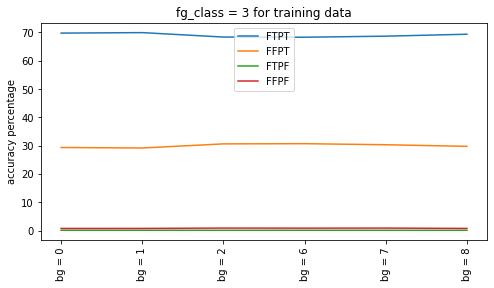

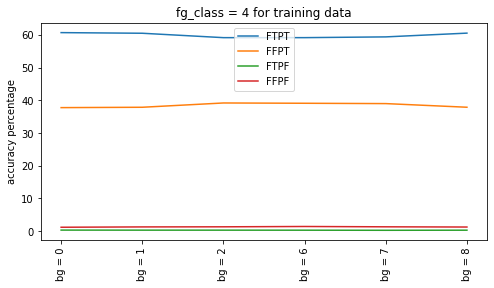

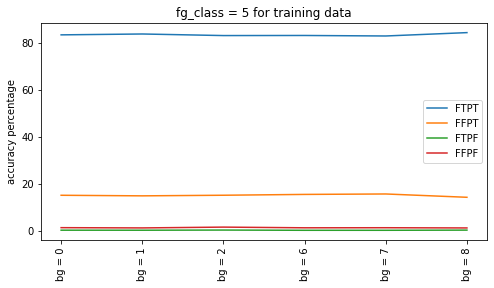

In [0]:
fig = plt.figure( figsize= (8,4))
plt.plot(id0, ftpt0,label = 'FTPT')
plt.plot(id0, ffpt0 , label = 'FFPT')
plt.plot(id0, ftpf0, label = 'FTPF')
plt.plot(id0, ffpf0, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg1)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg1)+' for training data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (8,4))
plt.plot(id0, ftpt1,label = 'FTPT')
plt.plot(id0, ffpt1 , label = 'FFPT')
plt.plot(id0, ftpf1, label = 'FTPF')
plt.plot(id0, ffpf1, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg2)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg2)+' for training data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (8,4))
plt.plot(id0, ftpt2,label = 'FTPT')
plt.plot(id0, ffpt2 , label = 'FFPT')
plt.plot(id0, ftpf2, label = 'FTPF')
plt.plot(id0, ffpf2, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg3)+' for training data'+".pdf", bbox_inches='tight')

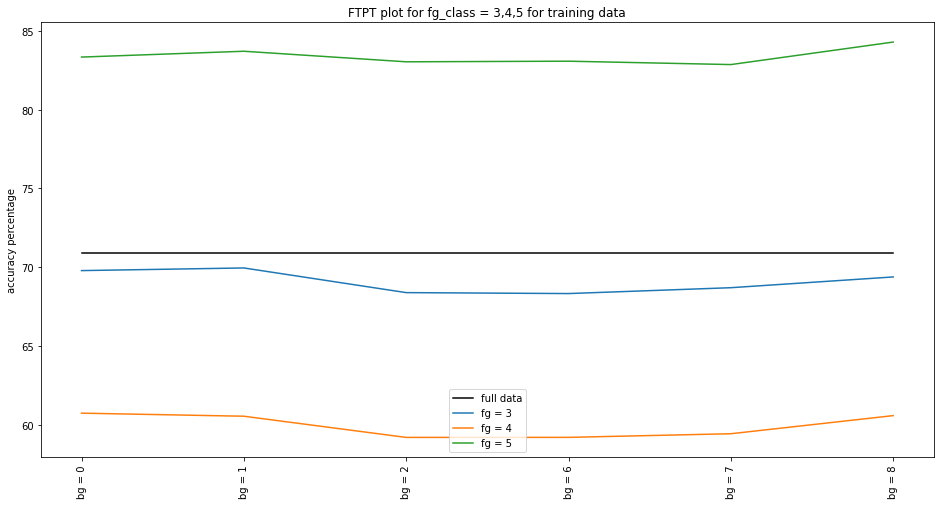

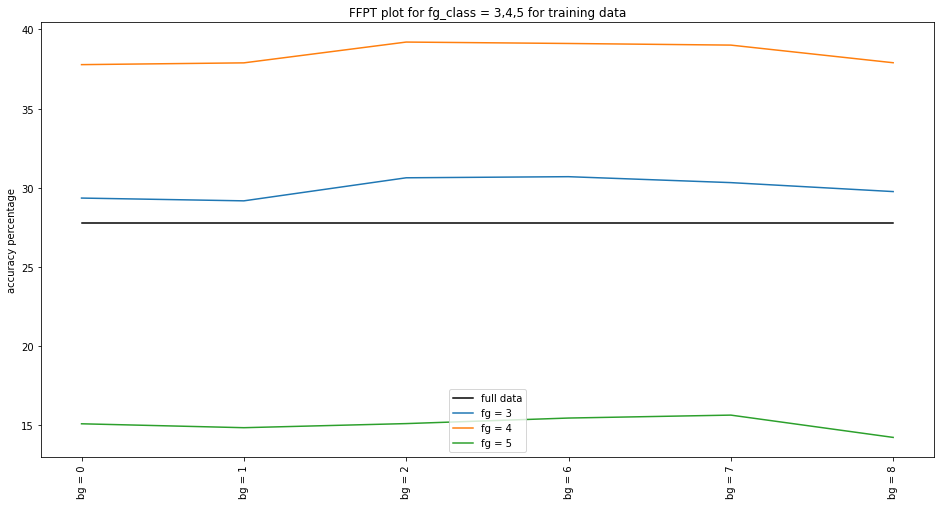

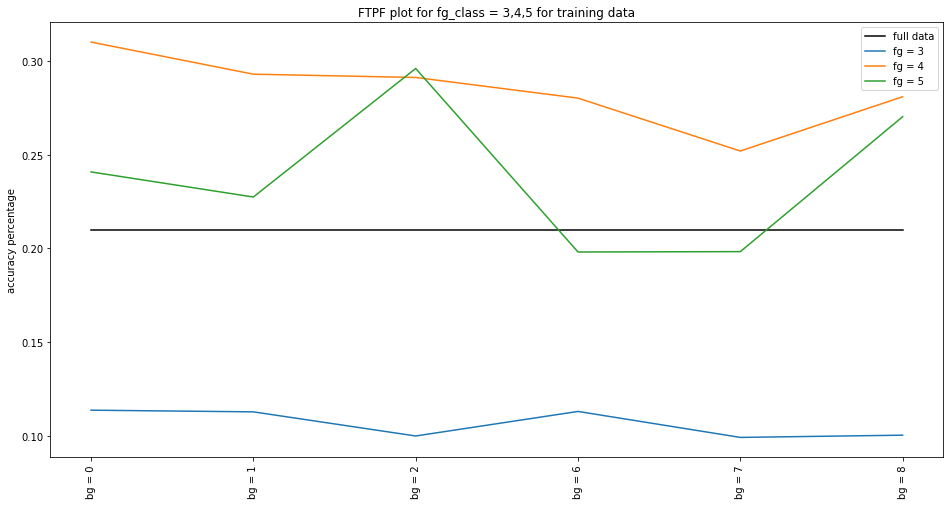

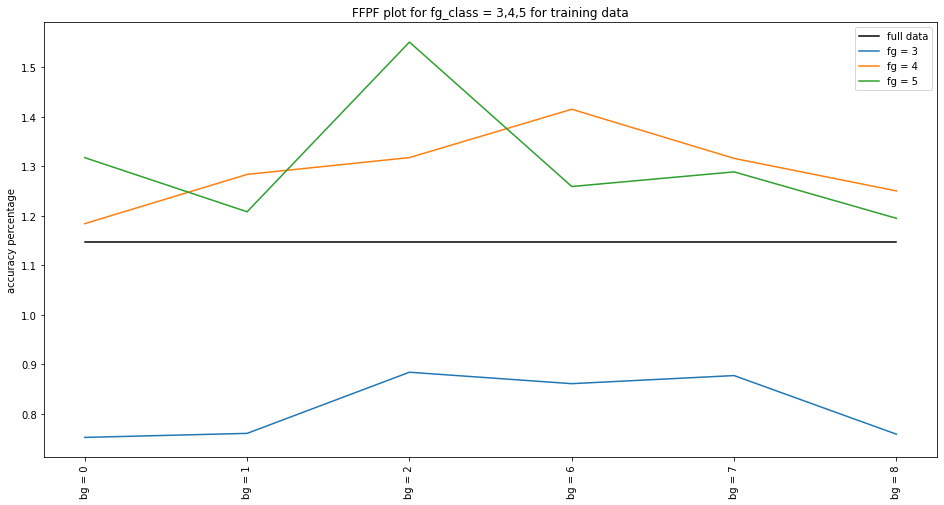

In [0]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpt_full, color='black', label = 'full data')
plt.plot(id0, ftpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpt_full, color='black', label = 'full data')
plt.plot(id0, ffpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpf_full, color='black', label = 'full data')
plt.plot(id0, ftpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpf_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpf_full, color='black', label = 'full data')
plt.plot(id0, ffpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpf_plot.pdf", bbox_inches='tight')

## On Test DATA


In [0]:
size1_table=[]
size1_table.append(test_entry)
entry_no = 2

# cnt=0
for a in fg :
  for i in bg:
    b1 = i
    count = 0
    correct = 0
    total = 0
    focus_true_pred_true = 0
    focus_false_pred_true = 0
    focus_true_pred_false = 0
    focus_false_pred_false = 0
    argmax_more_than_half = 0
    argmax_less_than_half = 0
    with torch.no_grad():
      for data in test_set:
        inputs, labels , fore_idx = data
        inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
        outputs, alphas, avg_images = fore_net(inputs)

        _, predicted = torch.max(outputs.data, 1)

        for m in range(labels.size(0)):
          # count
          if(count == 10000):
            break
          s = list_set_labels[count]
          # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
          if (a in s and b1 in s ):
            # print(str(a)+str(b1)+str(b2)+str(b3))
            total += 1
            focus = torch.argmax(alphas[m])
            if alphas[m][focus] >= 0.5 :
              argmax_more_than_half += 1
            else:
              argmax_less_than_half += 1

            if(focus == fore_idx[m] and predicted[m] == labels[m]):
                focus_true_pred_true += 1
            elif(focus != fore_idx[m] and predicted[m] == labels[m]):
              focus_false_pred_true += 1
            elif(focus == fore_idx[m] and predicted[m] != labels[m]):
              focus_true_pred_false += 1
            elif(focus != fore_idx[m] and predicted[m] != labels[m]):
              focus_false_pred_false += 1
          
          count += 1
        
      correct += (predicted == labels).sum().item()  
      entry = [entry_no,'fg = '+str(a) , 'bg = '+ str(b1), total]
      if total == 0:
        entry.append(0)
        entry.append(0)
        entry.append(0)
        entry.append(0)
      else:
        entry.append((100 * focus_true_pred_true / total))
        entry.append( (100 * focus_false_pred_true / total))
        entry.append( ( 100 * focus_true_pred_false / total))
        entry.append( ( 100 * focus_false_pred_false / total))
      entry.append( argmax_more_than_half)
      size1_table.append(entry)
      entry_no += 1

print("="*20+"Test DATA"+"="*20)
print(tabulate(size1_table, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Test DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [3, 4, 5]  bg = [0, 1, 2, 6, 7, 8, 9]          10000    60.43      13.07      7          19.5                7889
      2  fg = 3          bg = 0                               2408    62.5415    12.9568    6.39535    18.1063             1929
      3  fg = 3          bg = 1                               2417    62.019     12.7844    6.82664    18.3699             1933
      4  fg = 3          bg = 2                               2398    62.1768    12.6355    6.29691    18.8907             1902
      5  fg = 3          bg = 6                               2414    63.2974    12.2204    6.33803    18.1442             1933
      6  fg = 3          bg = 7                       

In [0]:
with open("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_" + str(fg_used) + "/" + "size1_on_test.csv", "w", newline ='') as f:
  thewriter = csv.writer(f)
  row = len(size1_table)
  thewriter.writerow(['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'])
  for i in range(row):
    thewriter.writerow(size1_table[i])

In [0]:
test = pd.read_csv("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_"+str(fg_used) + "/" + "size1_on_test.csv")
test.head()

S.No.        fg_class  ...    FFPF %   avg_img > 0.5
0      1  fg = [3, 4, 5]  ...  19.500000           7889
1      2          fg = 3  ...  18.106312           1929
2      3          fg = 3  ...  18.369880           1933
3      4          fg = 3  ...  18.890742           1902
4      5          fg = 3  ...  18.144159           1933

[5 rows x 9 columns]

In [0]:
test = np.array(test)
ftpt_full = test[0][4]
ffpt_full = test[0, 5]
ftpf_full = test[0, 6]
ffpf_full = test[0][7]
print(ftpt_full, ffpt_full, ftpf_full, ffpf_full)

l,u = 1,7  
id0 = test[l:u, 2]
ftpt0 = test[l:u, 4]
ffpt0 = test[l:u, 5]
ftpf0 = test[l:u, 6]
ffpf0 = test[l:u, 7]
print(ftpt0)

l,u = 8,14
id1 = test[l:u, 2]
ftpt1 = test[l:u, 4]
ffpt1 = test[l:u, 5]
ftpf1 = test[l:u, 6]
ffpf1 = test[l:u, 7]
print(ftpt1)

l,u = 15,21
id2 = test[l:u, 2]
ftpt2 = test[l:u, 4]
ffpt2 = test[l:u, 5]
ftpf2 = test[l:u, 6]
ffpf2 = test[l:u, 7]
print(ftpt2)

60.43 13.07 7.0 19.5
[62.541528239202655 62.0190318576748 62.1768140116764 63.29743164871582
 62.453066332916144 61.930860033726816]
[59.79469632164243 58.843252305113154 57.89473684210525 60.03452740612862
 57.39093604404914 60.27338744126442]
[59.740259740259745 59.611231101511876 59.832985386221296
 59.54623287671233 59.47191953059514 58.51565851565852]


In [0]:
path = '/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_' + str(fg_used) + "/size1/test/"

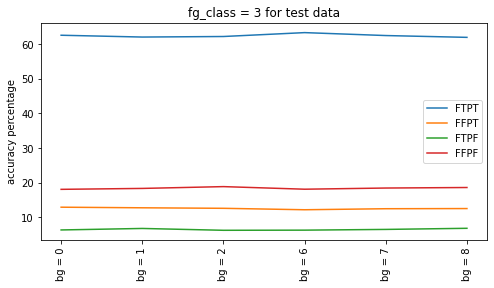

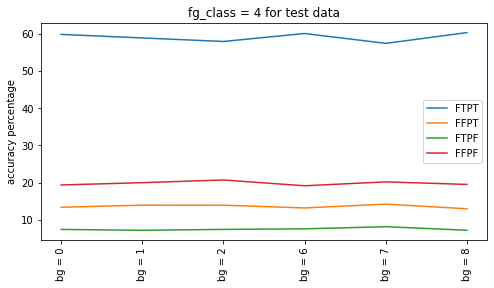

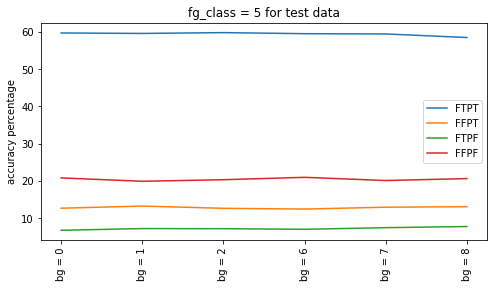

In [0]:
fig = plt.figure( figsize= (8,4))
plt.plot(id0, ftpt0,label = 'FTPT')
plt.plot(id0, ffpt0 , label = 'FFPT')
plt.plot(id0, ftpf0, label = 'FTPF')
plt.plot(id0, ffpf0, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg1)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg1)+' for test data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (8,4))
plt.plot(id0, ftpt1,label = 'FTPT')
plt.plot(id0, ffpt1 , label = 'FFPT')
plt.plot(id0, ftpf1, label = 'FTPF')
plt.plot(id0, ffpf1, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg2)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg2)+' for test data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (8,4))
plt.plot(id0, ftpt2,label = 'FTPT')
plt.plot(id0, ffpt2 , label = 'FFPT')
plt.plot(id0, ftpf2, label = 'FTPF')
plt.plot(id0, ffpf2, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg3)+' for test data'+".pdf", bbox_inches='tight')

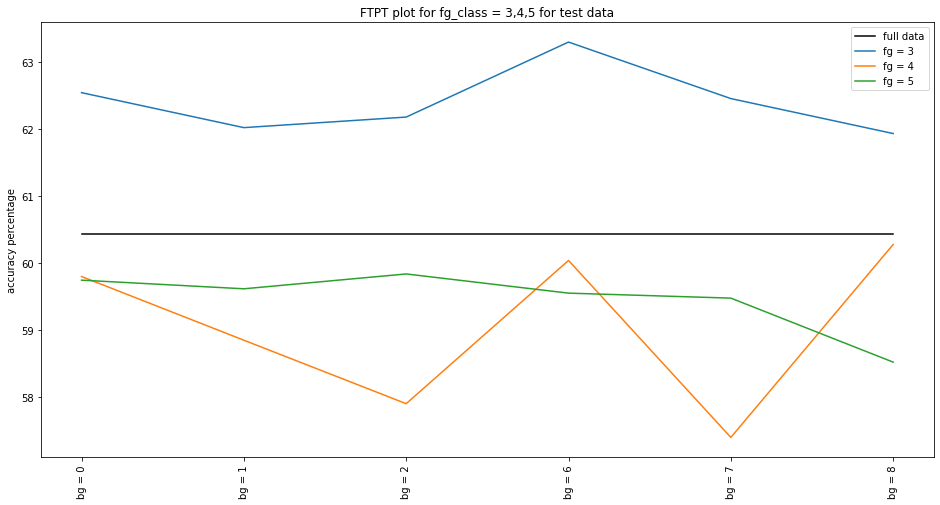

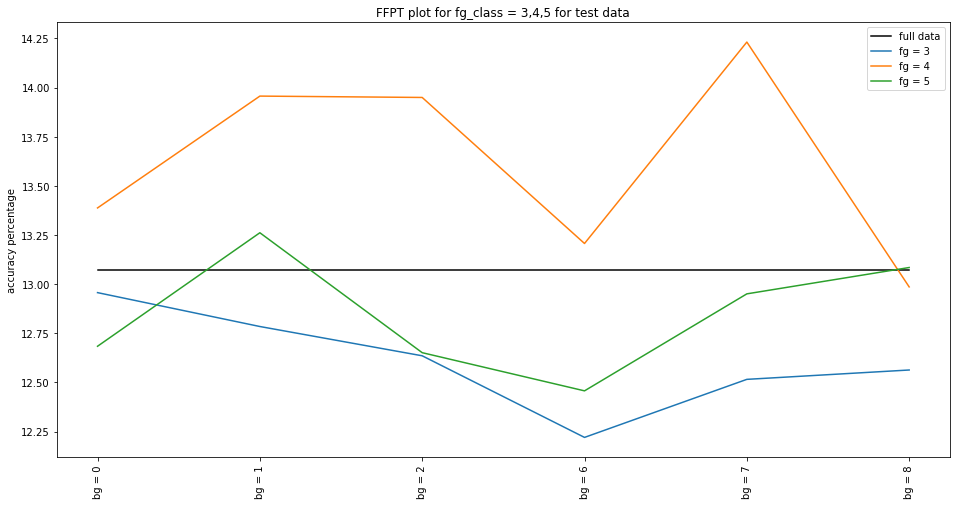

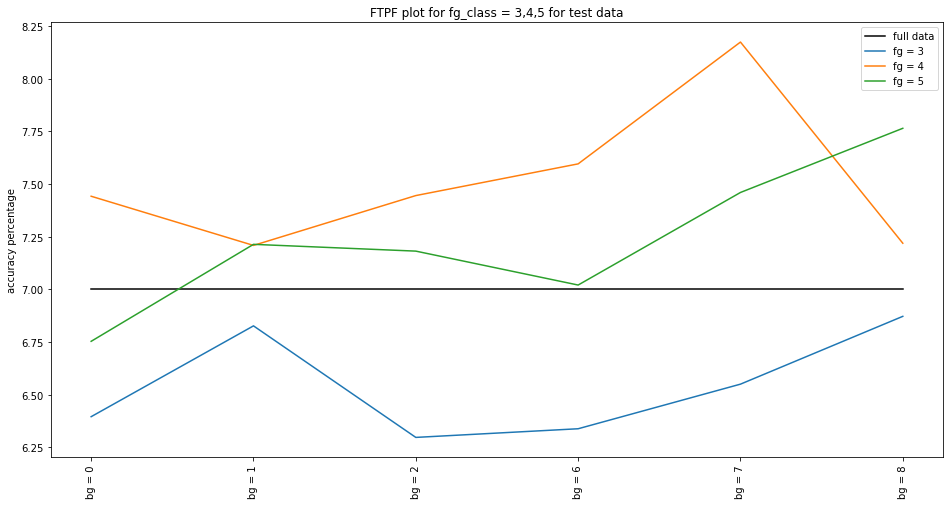

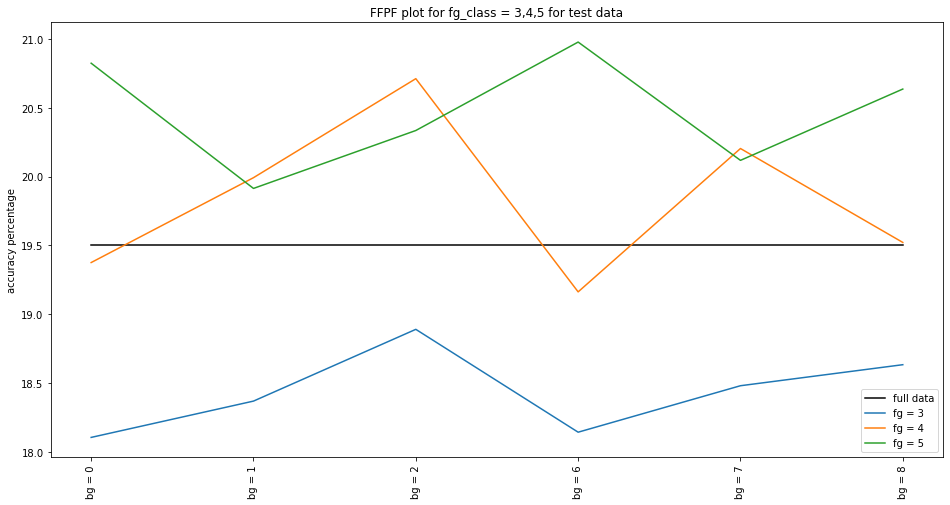

In [0]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpt_full, color='black', label = 'full data')
plt.plot(id0, ftpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpt_full, color='black', label = 'full data')
plt.plot(id0, ffpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpf_full, color='black', label = 'full data')
plt.plot(id0, ftpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpf_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpf_full, color='black', label = 'full data')
plt.plot(id0, ffpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpf_plot.pdf", bbox_inches='tight')

#Set Size 2 , Repetition allowed
## 33 in BG, 34 in BG, 35 in BG and so on
## On Training DATA


In [0]:
size2_table=[]
size2_table.append(train_entry)
entry_no = 2

# cnt=0
for a in fg :
  for i in bg:
    for j in bg:
      b1, b2 = i,j
      count = 0
      correct = 0
      total = 0
      focus_true_pred_true = 0
      focus_false_pred_true = 0
      focus_true_pred_false = 0
      focus_false_pred_false = 0
      argmax_more_than_half = 0
      argmax_less_than_half = 0
      with torch.no_grad():
        for data in train_set:
          inputs, labels , fore_idx = data
          inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
          outputs, alphas, avg_images = fore_net(inputs)

          _, predicted = torch.max(outputs.data, 1)

          for m in range(labels.size(0)):
            # count
            if(count == 30000):
              break
            s = list_set_labels[count]
            # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
            if (a in s and b1 in s and b2 in s ):
              # print(str(a)+str(b1)+str(b2)+str(b3))
              total += 1
              focus = torch.argmax(alphas[m])
              if alphas[m][focus] >= 0.5 :
                argmax_more_than_half += 1
              else:
                argmax_less_than_half += 1

              if(focus == fore_idx[m] and predicted[m] == labels[m]):
                  focus_true_pred_true += 1
              elif(focus != fore_idx[m] and predicted[m] == labels[m]):
                focus_false_pred_true += 1
              elif(focus == fore_idx[m] and predicted[m] != labels[m]):
                focus_true_pred_false += 1
              elif(focus != fore_idx[m] and predicted[m] != labels[m]):
                focus_false_pred_false += 1
            
            count += 1
          
        correct += (predicted == labels).sum().item()  
        entry = [entry_no,'fg = '+str(a) , 'bg = '+ str(b1) + str(b2), total]
        if total == 0:
          entry.append(0)
          entry.append(0)
          entry.append(0)
          entry.append(0)
        else:
          entry.append((100 * focus_true_pred_true / total))
          entry.append( (100 * focus_false_pred_true / total))
          entry.append( ( 100 * focus_true_pred_false / total))
          entry.append( ( 100 * focus_false_pred_false / total))
        entry.append( argmax_more_than_half)
        size2_table.append(entry)
        entry_no += 1

print("="*20+"Training DATA"+"="*20)
print(tabulate(size2_table, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Training DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [3, 4, 5]  bg = [0, 1, 2, 6, 7, 8, 9]          30000    70.8833    27.76    0.21        1.14667             24688
      2  fg = 3          bg = 00                              7042    69.7813    29.3525  0.113604    0.752627             5788
      3  fg = 3          bg = 01                              4864    70.6826    28.5979  0.143914    0.575658             4008
      4  fg = 3          bg = 02                              4840    68.7603    30.3512  0.103306    0.785124             3991
      5  fg = 3          bg = 06                              4858    68.8555    30.28    0.123508    0.741046             3968
      6  fg = 3          bg = 07                  

In [0]:
with open("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_" + str(fg_used) + "/" + "size2_on_train.csv", "w", newline ='') as f:
  thewriter = csv.writer(f)
  row = len(size2_table)
  thewriter.writerow(['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'])
  for i in range(row):
    thewriter.writerow(size2_table[i])

In [0]:
train = pd.read_csv("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_"+str(fg_used) + "/" + "size2_on_train.csv")
train.head()

S.No.        fg_class  ...   FFPF %   avg_img > 0.5
0      1  fg = [3, 4, 5]  ...  1.146667          24688
1      2          fg = 3  ...  0.752627           5788
2      3          fg = 3  ...  0.575658           4008
3      4          fg = 3  ...  0.785124           3991
4      5          fg = 3  ...  0.741046           3968

[5 rows x 9 columns]

In [0]:
train = np.array(train)
ftpt_full = train[0][4]
ffpt_full = train[0, 5]
ftpf_full = train[0, 6]
ffpf_full = train[0][7]
print(ftpt_full, ffpt_full, ftpf_full, ffpf_full)

l,u = 1,49
id0 = train[l:u, 2]
ftpt0 = train[l:u, 4]
ffpt0 = train[l:u, 5]
ftpf0 = train[l:u, 6]
ffpf0 = train[l:u, 7]
print(ftpt0[0:4] )

l,u = 50,98
id1 = train[l:u, 2]
ftpt1 = train[l:u, 4]
ffpt1 = train[l:u, 5]
ftpf1 = train[l:u, 6]
ffpf1 = train[l:u, 7]
print(ftpt1[0:4] )

l,u = 99,147
id2 = train[l:u, 2]
ftpt2 = train[l:u, 4]
ffpt2 = train[l:u, 5]
ftpf2 = train[l:u, 6]
ffpf2 = train[l:u, 7]
print(ftpt2[0:4] )

70.88333333333334 27.76 0.21 1.1466666666666667
[69.78131212723656 70.68256578947368 68.7603305785124 68.85549608892548]
[60.72737524668735 61.33882595262615 59.98371667005903 59.84739121468344]
[83.34277620396601 83.56534386037816 83.1104710964822 82.93848711554448]


In [0]:
path = '/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_' + str(fg_used) + "/size2/train/"

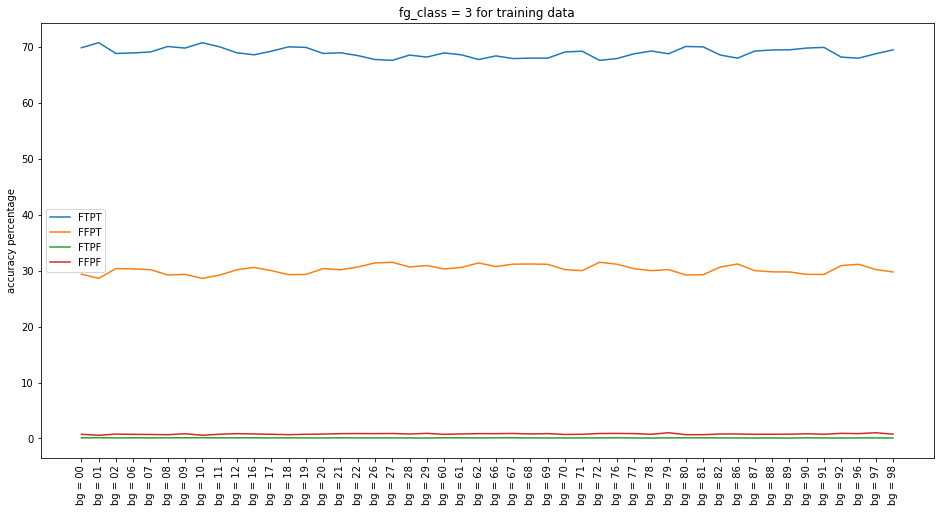

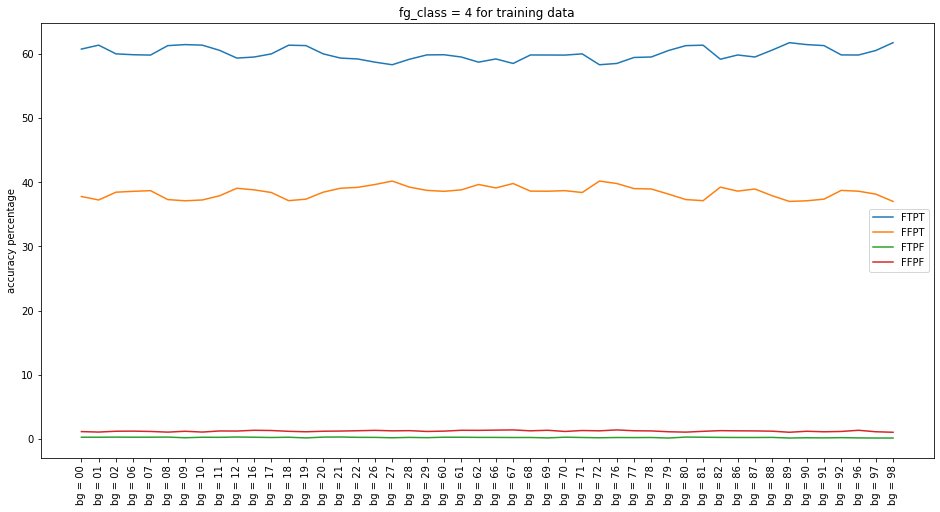

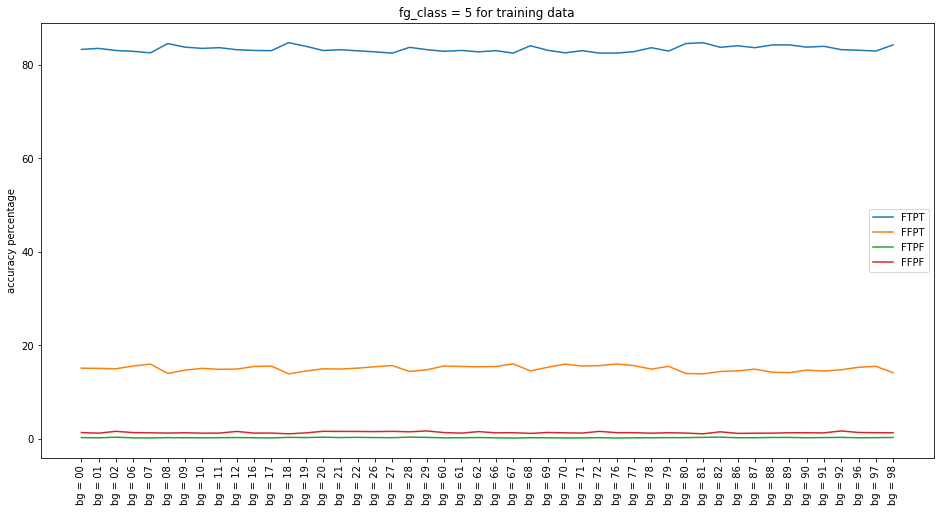

In [0]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt0,label = 'FTPT')
plt.plot(id0, ffpt0 , label = 'FFPT')
plt.plot(id0, ftpf0, label = 'FTPF')
plt.plot(id0, ffpf0, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg1)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg1)+' for training data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt1,label = 'FTPT')
plt.plot(id0, ffpt1 , label = 'FFPT')
plt.plot(id0, ftpf1, label = 'FTPF')
plt.plot(id0, ffpf1, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg2)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg2)+' for training data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt2,label = 'FTPT')
plt.plot(id0, ffpt2 , label = 'FFPT')
plt.plot(id0, ftpf2, label = 'FTPF')
plt.plot(id0, ffpf2, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg3)+' for training data'+".pdf", bbox_inches='tight')

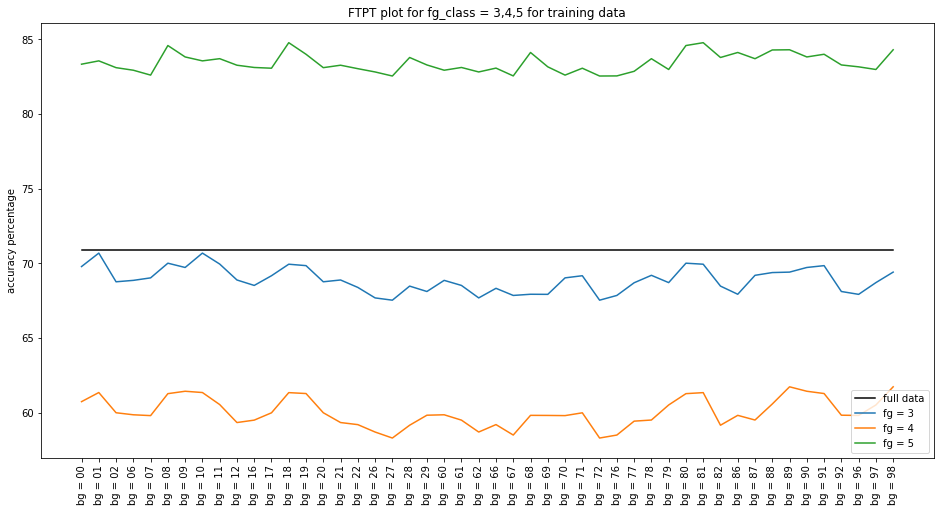

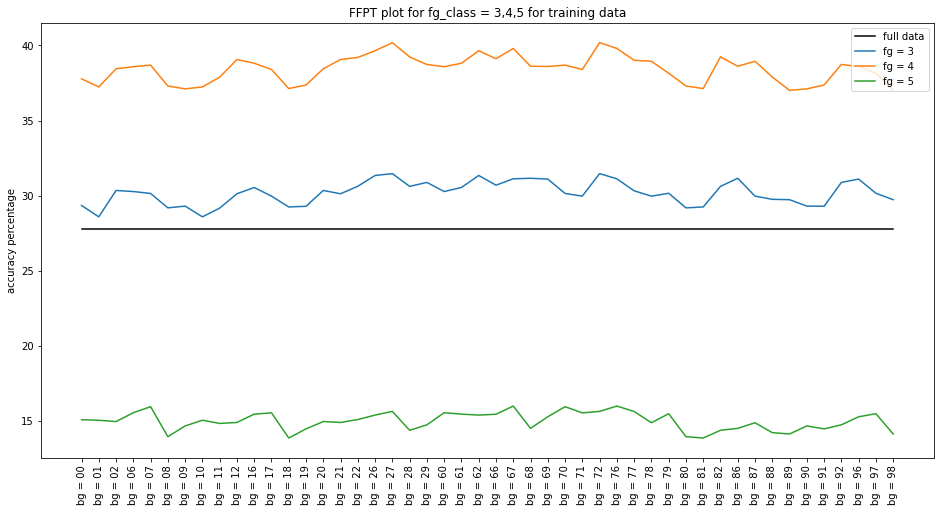

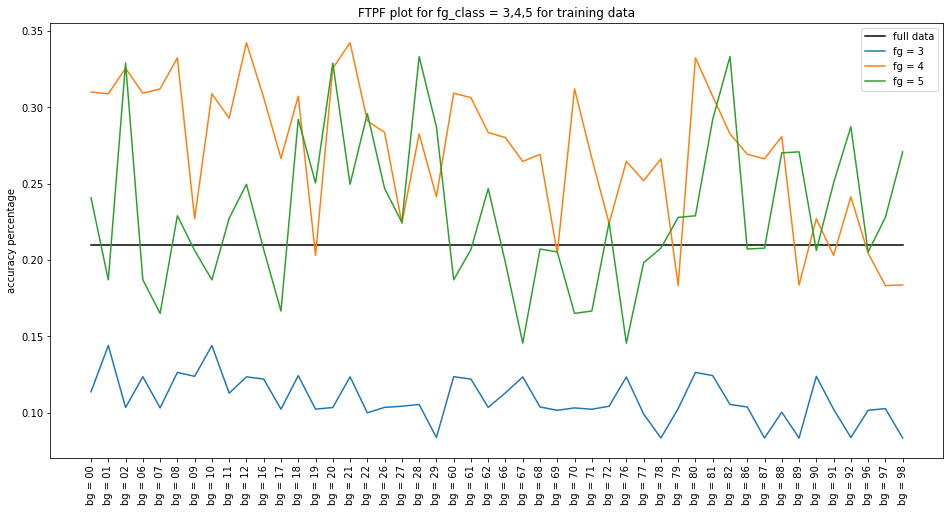

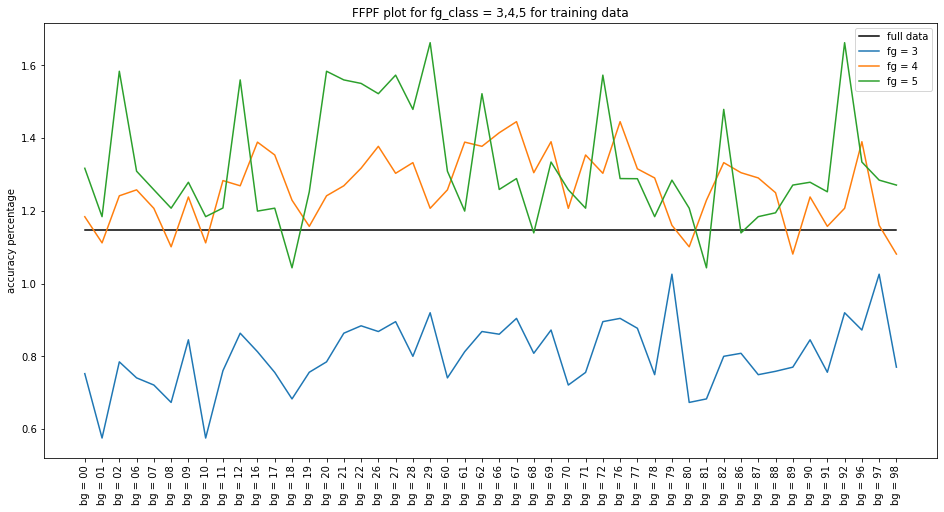

In [0]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpt_full, color='black', label = 'full data')
plt.plot(id0, ftpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpt_full, color='black', label = 'full data')
plt.plot(id0, ffpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpf_full, color='black', label = 'full data')
plt.plot(id0, ftpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpf_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpf_full, color='black', label = 'full data')
plt.plot(id0, ffpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpf_plot.pdf", bbox_inches='tight')

## On Test DATA


In [0]:
size2_table_test=[]
size2_table_test.append(test_entry)
entry_no = 2

# cnt=0
for a in fg :
  for i in bg:
    for j in bg:
      b1,b2 = i,j
      count = 0
      correct = 0
      total = 0
      focus_true_pred_true = 0
      focus_false_pred_true = 0
      focus_true_pred_false = 0
      focus_false_pred_false = 0
      argmax_more_than_half = 0
      argmax_less_than_half = 0
      with torch.no_grad():
        for data in test_set:
          inputs, labels , fore_idx = data
          inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
          outputs, alphas, avg_images = fore_net(inputs)

          _, predicted = torch.max(outputs.data, 1)

          for m in range(labels.size(0)):
            # count
            if(count == 10000):
              break
            s = list_set_labels[count]
            # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
            if (a in s and b1 in s and b2 in s ):
              # print(str(a)+str(b1)+str(b2)+str(b3))
              total += 1
              focus = torch.argmax(alphas[m])
              if alphas[m][focus] >= 0.5 :
                argmax_more_than_half += 1
              else:
                argmax_less_than_half += 1

              if(focus == fore_idx[m] and predicted[m] == labels[m]):
                  focus_true_pred_true += 1
              elif(focus != fore_idx[m] and predicted[m] == labels[m]):
                focus_false_pred_true += 1
              elif(focus == fore_idx[m] and predicted[m] != labels[m]):
                focus_true_pred_false += 1
              elif(focus != fore_idx[m] and predicted[m] != labels[m]):
                focus_false_pred_false += 1
            
            count += 1
          
        correct += (predicted == labels).sum().item()  
        entry = [entry_no,'fg = '+str(a) , 'bg = '+ str(b1)+str(b2), total]
        if total == 0:
          entry.append(0)
          entry.append(0)
          entry.append(0)
          entry.append(0)
        else:
          entry.append((100 * focus_true_pred_true / total))
          entry.append( (100 * focus_false_pred_true / total))
          entry.append( ( 100 * focus_true_pred_false / total))
          entry.append( ( 100 * focus_false_pred_false / total))
        entry.append( argmax_more_than_half)
        size2_table_test.append(entry)
        entry_no += 1

print("="*20+"Test DATA"+"="*20)
print(tabulate(size2_table_test, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Test DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [3, 4, 5]  bg = [0, 1, 2, 6, 7, 8, 9]          10000    60.43      13.07      7          19.5                7889
      2  fg = 3          bg = 00                              2408    62.5415    12.9568    6.39535    18.1063             1929
      3  fg = 3          bg = 01                              1677    61.8366    13.2379    6.85748    18.068              1346
      4  fg = 3          bg = 02                              1662    62.6354    12.6955    6.01685    18.6522             1326
      5  fg = 3          bg = 06                              1666    63.6255    12.3649    6.12245    17.8872             1332
      6  fg = 3          bg = 07                      

In [0]:
with open("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_" + str(fg_used) + "/" + "size2_on_test.csv", "w", newline ='') as f:
  thewriter = csv.writer(f)
  row = len(size2_table_test)
  thewriter.writerow(['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'])
  for i in range(row):
    thewriter.writerow(size2_table_test[i])

In [0]:
test = pd.read_csv("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_"+str(fg_used) + "/" + "size2_on_test.csv")
test.head()

S.No.        fg_class  ...    FFPF %   avg_img > 0.5
0      1  fg = [3, 4, 5]  ...  19.500000           7889
1      2          fg = 3  ...  18.106312           1929
2      3          fg = 3  ...  18.067979           1346
3      4          fg = 3  ...  18.652226           1326
4      5          fg = 3  ...  17.887155           1332

[5 rows x 9 columns]

In [0]:
test = np.array(test)
ftpt_full = test[0][4]
ffpt_full = test[0, 5]
ftpf_full = test[0, 6]
ffpf_full = test[0][7]
print(ftpt_full, ffpt_full, ftpf_full, ffpf_full)

l,u = 1,49
id0 = test[l:u, 2]
ftpt0 = test[l:u, 4]
ffpt0 = test[l:u, 5]
ftpf0 = test[l:u, 6]
ffpf0 = test[l:u, 7]
print(ftpt0[0:4])

l,u = 50,98
id1 = test[l:u, 2]
ftpt1 = test[l:u, 4]
ffpt1 = test[l:u, 5]
ftpf1 = test[l:u, 6]
ffpf1 = test[l:u, 7]
print(ftpt1[0:4] )

l,u = 99,147
id2 = test[l:u, 2]
ftpt2 = test[l:u, 4]
ffpt2 = test[l:u, 5]
ftpf2 = test[l:u, 6]
ffpf2 = test[l:u, 7]
print(ftpt2[0:4] )

60.43 13.07 7.0 19.5
[62.541528239202655 61.836612999403705 62.63537906137184 63.62545018007203]
[59.79469632164243 59.88875154511742 58.04195804195804 60.60606060606061]
[59.740259740259745 60.12779552715654 59.72906403940887 59.75609756097561]


In [0]:
path = '/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_' + str(fg_used) + "/size2/test/"

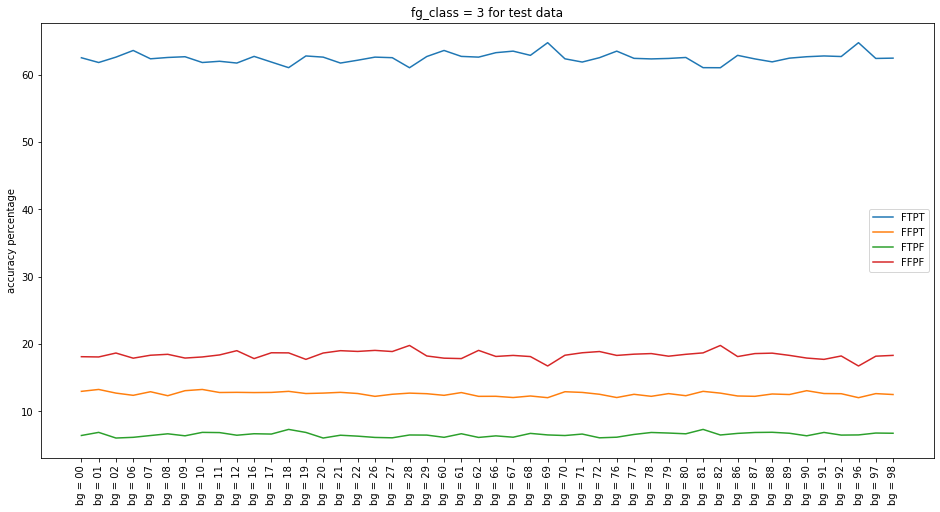

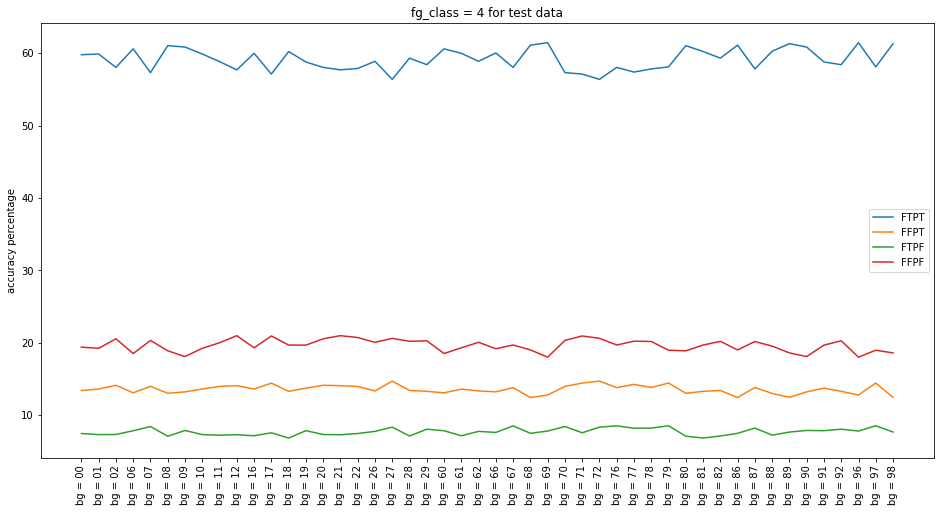

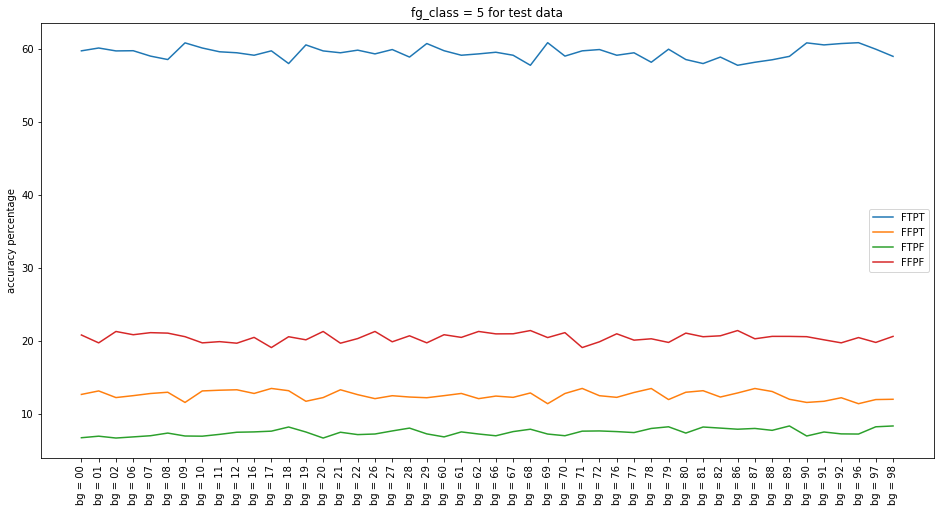

In [0]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt0,label = 'FTPT')
plt.plot(id0, ffpt0 , label = 'FFPT')
plt.plot(id0, ftpf0, label = 'FTPF')
plt.plot(id0, ffpf0, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg1)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg1)+' for test data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt1,label = 'FTPT')
plt.plot(id0, ffpt1 , label = 'FFPT')
plt.plot(id0, ftpf1, label = 'FTPF')
plt.plot(id0, ffpf1, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg2)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg2)+' for test data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt2,label = 'FTPT')
plt.plot(id0, ffpt2 , label = 'FFPT')
plt.plot(id0, ftpf2, label = 'FTPF')
plt.plot(id0, ffpf2, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg3)+' for test data'+".pdf", bbox_inches='tight')

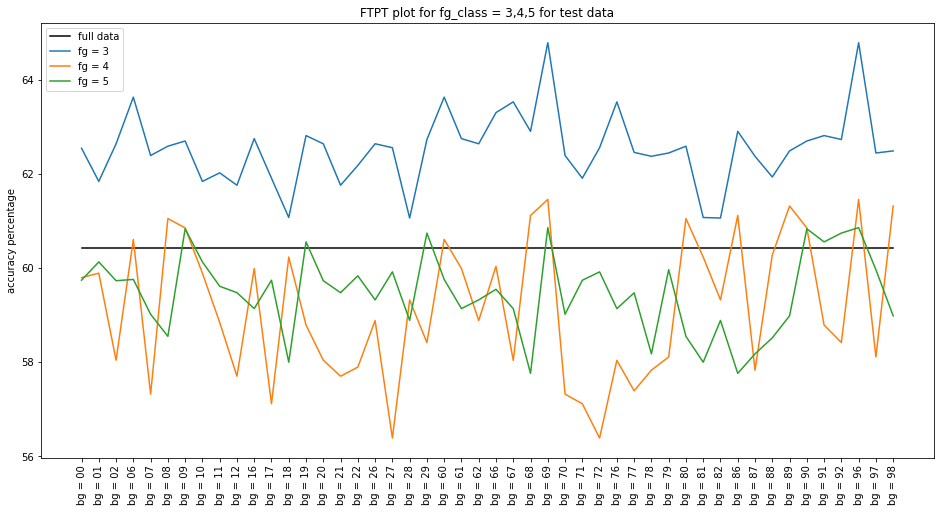

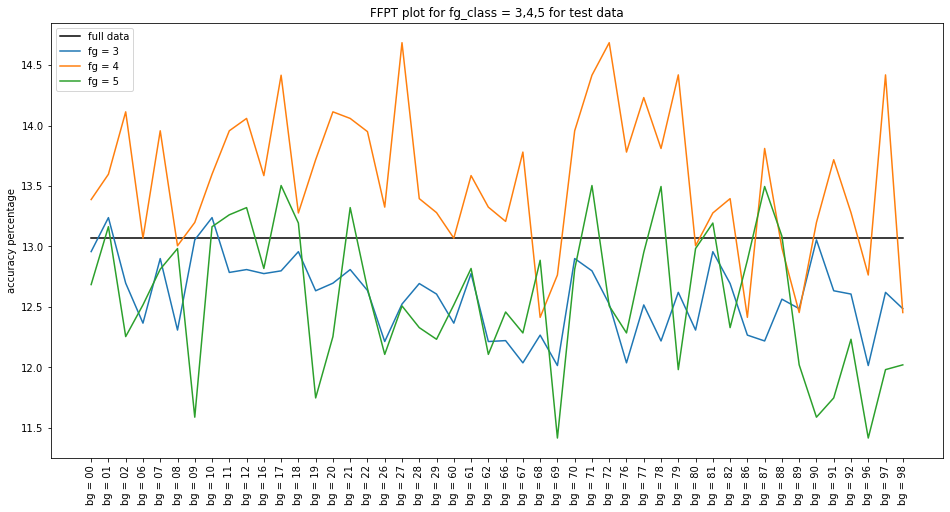

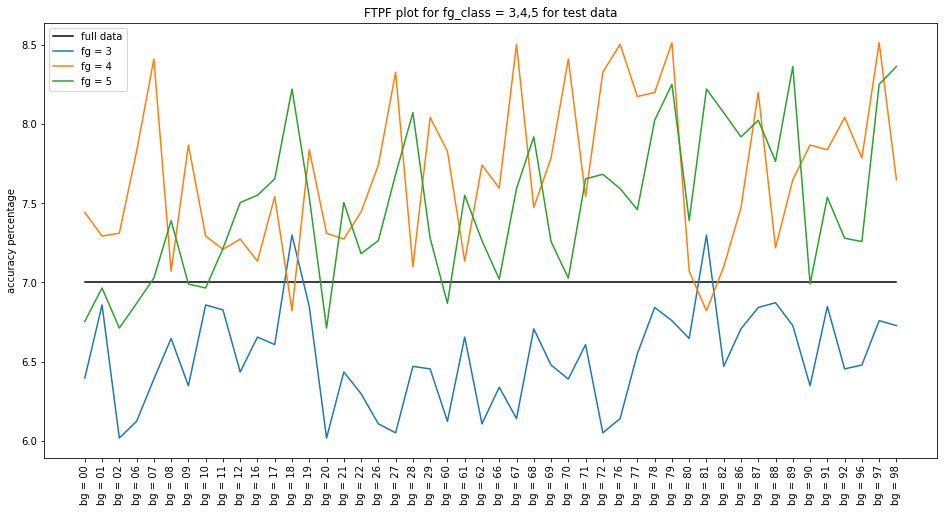

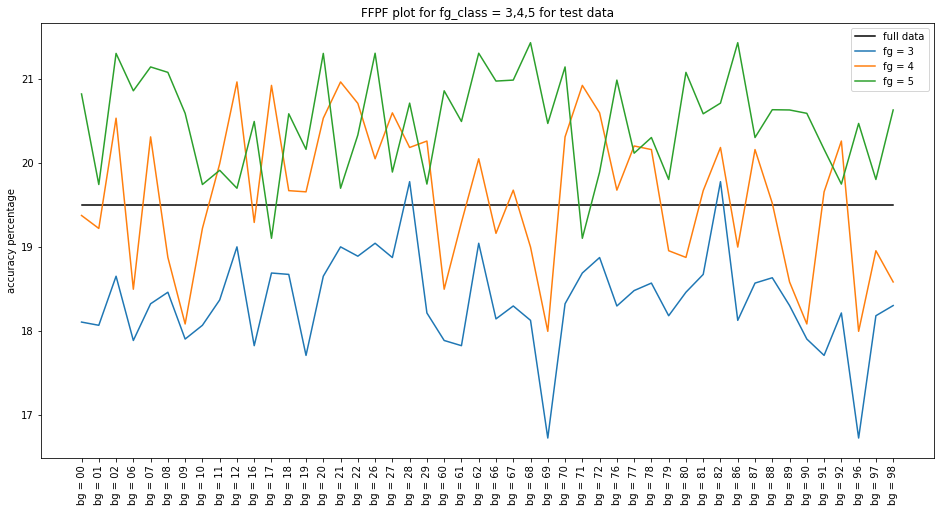

In [0]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpt_full, color='black', label = 'full data')
plt.plot(id0, ftpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpt_full, color='black', label = 'full data')
plt.plot(id0, ffpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpf_full, color='black', label = 'full data')
plt.plot(id0, ftpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpf_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpf_full, color='black', label = 'full data')
plt.plot(id0, ffpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpf_plot.pdf", bbox_inches='tight')

#Set Size 3 , Repetition allowed
## 333 in BG, 334 in BG, 335 in BG and so on
## On Training DATA


In [0]:
size3_table=[]
size3_table.append(train_entry)
entry_no = 2

# cnt=0
for a in fg :
  for i in bg:
    for j in bg:
      for k in bg:
        b1, b2, b3 = i,j,k
        count = 0
        correct = 0
        total = 0
        focus_true_pred_true = 0
        focus_false_pred_true = 0
        focus_true_pred_false = 0
        focus_false_pred_false = 0
        argmax_more_than_half = 0
        argmax_less_than_half = 0
        with torch.no_grad():
          for data in train_set:
            inputs, labels , fore_idx = data
            inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
            outputs, alphas, avg_images = fore_net(inputs)

            _, predicted = torch.max(outputs.data, 1)

            for m in range(labels.size(0)):
              # count
              if(count == 30000):
                break
              s = list_set_labels[count]
              # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
              if (a in s and b1 in s and b2 in s and b3 in s ):
                # print(str(a)+str(b1)+str(b2)+str(b3))
                total += 1
                focus = torch.argmax(alphas[m])
                if alphas[m][focus] >= 0.5 :
                  argmax_more_than_half += 1
                else:
                  argmax_less_than_half += 1

                if(focus == fore_idx[m] and predicted[m] == labels[m]):
                    focus_true_pred_true += 1
                elif(focus != fore_idx[m] and predicted[m] == labels[m]):
                  focus_false_pred_true += 1
                elif(focus == fore_idx[m] and predicted[m] != labels[m]):
                  focus_true_pred_false += 1
                elif(focus != fore_idx[m] and predicted[m] != labels[m]):
                  focus_false_pred_false += 1
              
              count += 1
            
          correct += (predicted == labels).sum().item()  
          entry = [entry_no,'fg = '+str(a) , 'bg = '+ str(b1) + str(b2) +str(b3), total]
          if total == 0:
            entry.append(0)
            entry.append(0)
            entry.append(0)
            entry.append(0)
          else:
            entry.append((100 * focus_true_pred_true / total))
            entry.append( (100 * focus_false_pred_true / total))
            entry.append( ( 100 * focus_true_pred_false / total))
            entry.append( ( 100 * focus_false_pred_false / total))
          entry.append( argmax_more_than_half)
          size3_table.append(entry)
          entry_no += 1

print("="*20+"Training DATA"+"="*20)
print(tabulate(size3_table, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Training DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [3, 4, 5]  bg = [0, 1, 2, 6, 7, 8, 9]          30000    70.8833    27.76    0.21        1.14667             24688
      2  fg = 3          bg = 000                             7042    69.7813    29.3525  0.113604    0.752627             5788
      3  fg = 3          bg = 001                             4864    70.6826    28.5979  0.143914    0.575658             4008
      4  fg = 3          bg = 002                             4840    68.7603    30.3512  0.103306    0.785124             3991
      5  fg = 3          bg = 006                             4858    68.8555    30.28    0.123508    0.741046             3968
      6  fg = 3          bg = 007                 

In [0]:
with open("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_" + str(fg_used) + "/" + "size3_on_train.csv", "w", newline ='') as f:
  thewriter = csv.writer(f)
  row = len(size3_table)
  thewriter.writerow(['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'])
  for i in range(row):
    thewriter.writerow(size3_table[i])

In [58]:
train = pd.read_csv("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_"+str(fg_used) + "/" + "size3_on_train.csv")
train.head()

S.No.        fg_class  ...   FFPF %   avg_img > 0.5
0      1  fg = [3, 4, 5]  ...  1.146667          24688
1      2          fg = 3  ...  0.752627           5788
2      3          fg = 3  ...  0.575658           4008
3      4          fg = 3  ...  0.785124           3991
4      5          fg = 3  ...  0.741046           3968

[5 rows x 9 columns]

In [59]:
train = np.array(train)
ftpt_full = train[0][4]
ffpt_full = train[0, 5]
ftpf_full = train[0, 6]
ffpf_full = train[0][7]
print(ftpt_full, ffpt_full, ftpf_full, ffpf_full)

l,u = 1,343
id0 = train[l:u, 2]
ftpt0 = train[l:u, 4]
ffpt0 = train[l:u, 5]
ftpf0 = train[l:u, 6]
ffpf0 = train[l:u, 7]
print(ftpt0[0:4] )

l,u = 344,686
id1 = train[l:u, 2]
ftpt1 = train[l:u, 4]
ffpt1 = train[l:u, 5]
ftpf1 = train[l:u, 6]
ffpf1 = train[l:u, 7]
print(ftpt1[0:4] )

l,u = 687,1029
id2 = train[l:u, 2]
ftpt2 = train[l:u, 4]
ffpt2 = train[l:u, 5]
ftpf2 = train[l:u, 6]
ffpf2 = train[l:u, 7]
print(ftpt2[0:4] )

70.88333333333334 27.76 0.21 1.1466666666666667
[69.78131212723656 70.68256578947368 68.7603305785124 68.85549608892548]
[60.72737524668735 61.33882595262615 59.98371667005903 59.84739121468344]
[83.34277620396601 83.56534386037816 83.1104710964822 82.93848711554448]


In [0]:
path = '/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_' + str(fg_used) + "/size3/train/"

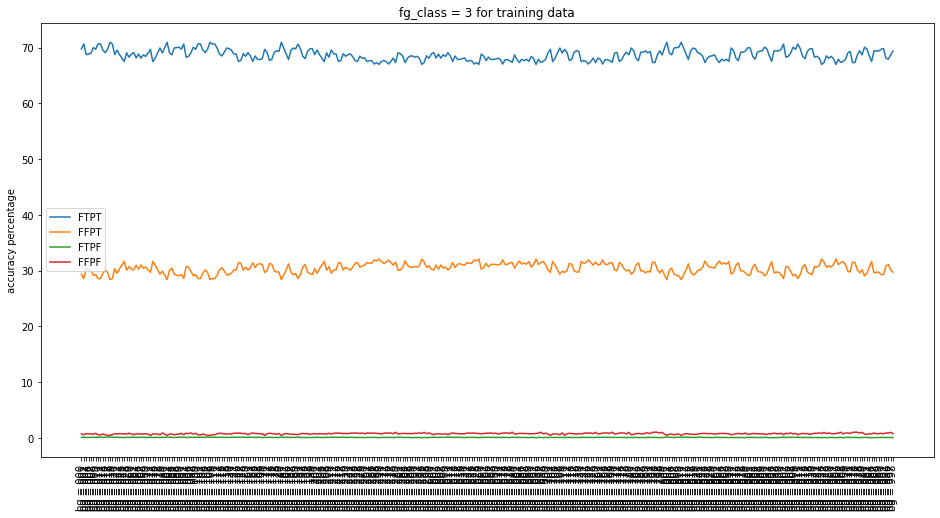

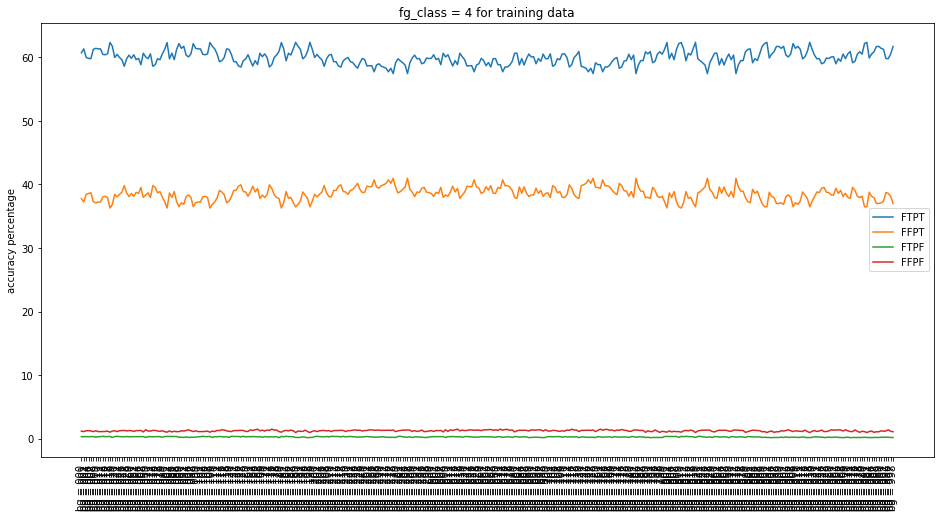

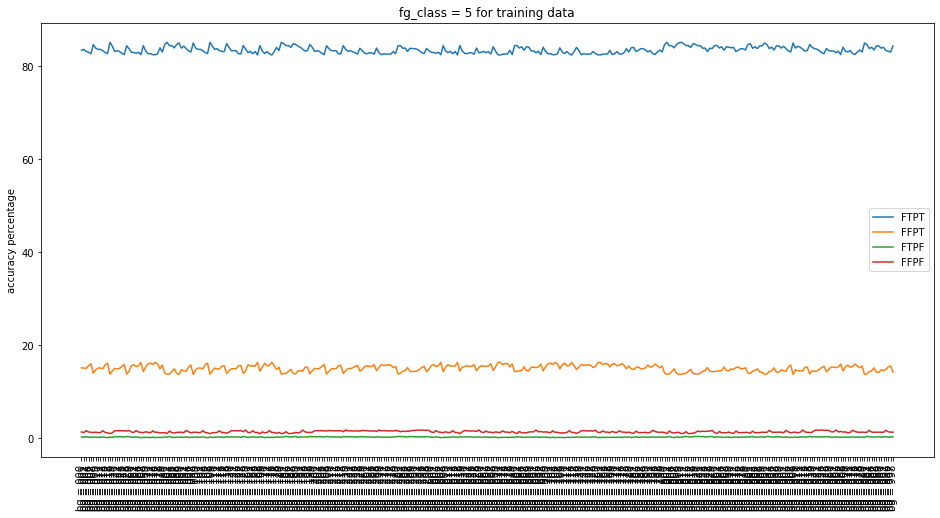

In [61]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt0,label = 'FTPT')
plt.plot(id0, ffpt0 , label = 'FFPT')
plt.plot(id0, ftpf0, label = 'FTPF')
plt.plot(id0, ffpf0, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg1)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg1)+' for training data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt1,label = 'FTPT')
plt.plot(id0, ffpt1 , label = 'FFPT')
plt.plot(id0, ftpf1, label = 'FTPF')
plt.plot(id0, ffpf1, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg2)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg2)+' for training data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt2,label = 'FTPT')
plt.plot(id0, ffpt2 , label = 'FFPT')
plt.plot(id0, ftpf2, label = 'FTPF')
plt.plot(id0, ffpf2, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg3)+' for training data'+".pdf", bbox_inches='tight')

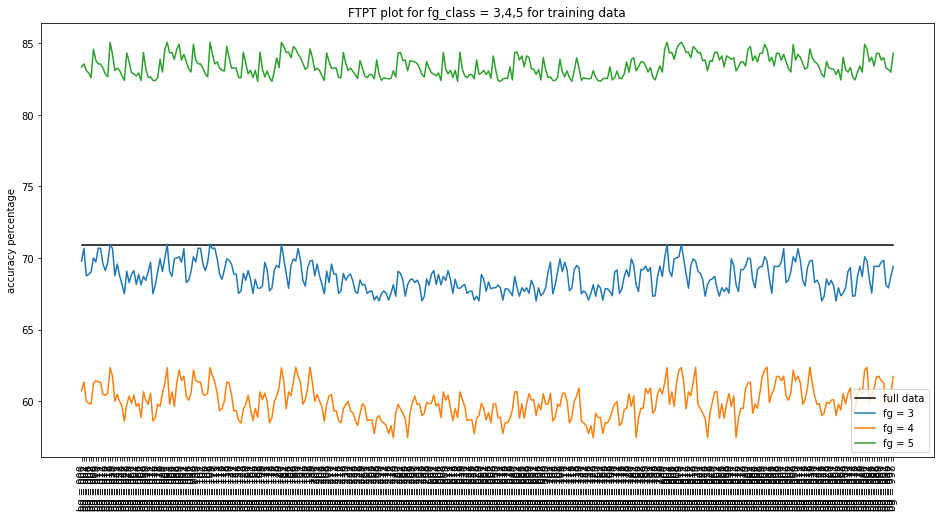

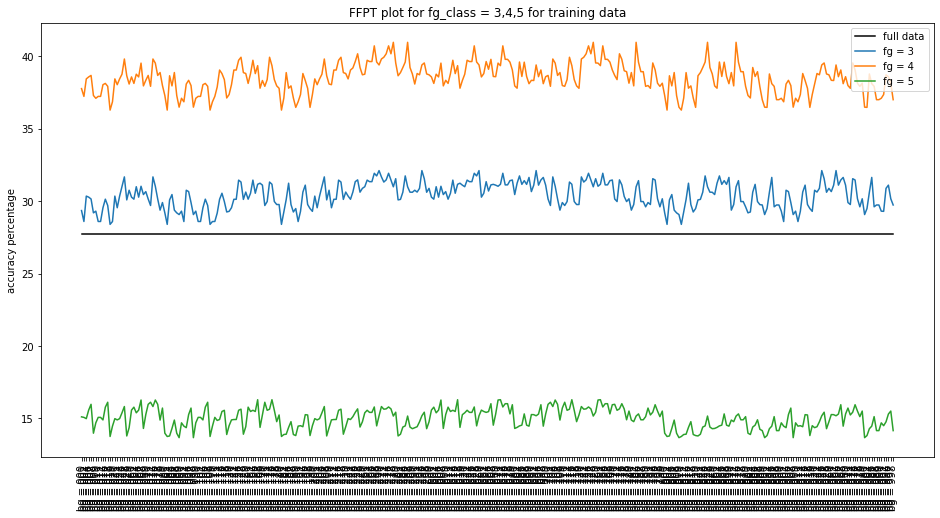

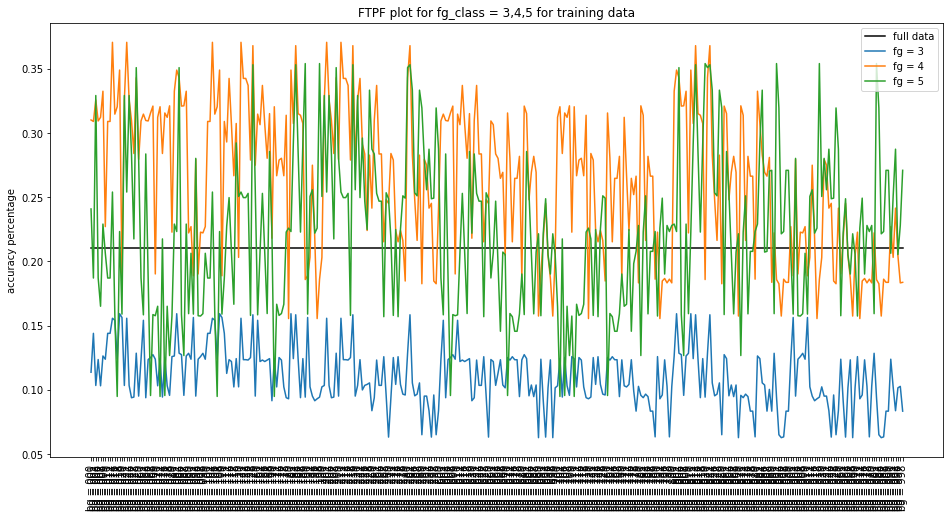

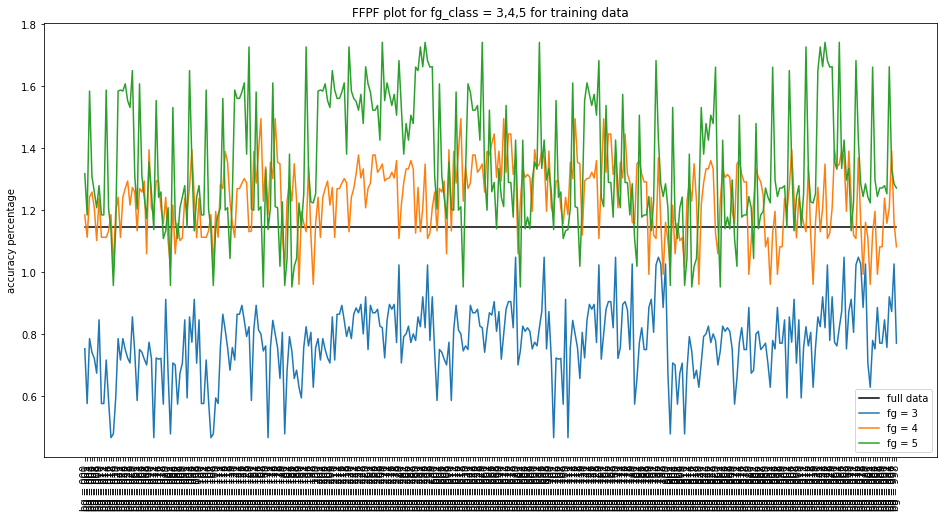

In [62]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpt_full, color='black', label = 'full data')
plt.plot(id0, ftpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpt_full, color='black', label = 'full data')
plt.plot(id0, ffpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpf_full, color='black', label = 'full data')
plt.plot(id0, ftpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpf_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpf_full, color='black', label = 'full data')
plt.plot(id0, ffpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpf_plot.pdf", bbox_inches='tight')

## On Test DATA


In [63]:
size3_table_test=[]
size3_table_test.append(test_entry)
entry_no = 2

# cnt=0
for a in fg :
  for i in bg:
    for j in bg:
      for k in bg:
        b1,b2,b3 = i,j,k
        count = 0
        correct = 0
        total = 0
        focus_true_pred_true = 0
        focus_false_pred_true = 0
        focus_true_pred_false = 0
        focus_false_pred_false = 0
        argmax_more_than_half = 0
        argmax_less_than_half = 0
        with torch.no_grad():
          for data in test_set:
            inputs, labels , fore_idx = data
            inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
            outputs, alphas, avg_images = fore_net(inputs)

            _, predicted = torch.max(outputs.data, 1)

            for m in range(labels.size(0)):
              # count
              if(count == 10000):
                break
              s = list_set_labels[count]
              # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
              if (a in s and b1 in s and b2 in s and b3 in s):
                # print(str(a)+str(b1)+str(b2)+str(b3))
                total += 1
                focus = torch.argmax(alphas[m])
                if alphas[m][focus] >= 0.5 :
                  argmax_more_than_half += 1
                else:
                  argmax_less_than_half += 1

                if(focus == fore_idx[m] and predicted[m] == labels[m]):
                    focus_true_pred_true += 1
                elif(focus != fore_idx[m] and predicted[m] == labels[m]):
                  focus_false_pred_true += 1
                elif(focus == fore_idx[m] and predicted[m] != labels[m]):
                  focus_true_pred_false += 1
                elif(focus != fore_idx[m] and predicted[m] != labels[m]):
                  focus_false_pred_false += 1
              
              count += 1
            
          correct += (predicted == labels).sum().item()  
          entry = [entry_no,'fg = '+str(a) , 'bg = '+ str(b1)+str(b2)+str(b3), total]
          if total == 0:
            entry.append(0)
            entry.append(0)
            entry.append(0)
            entry.append(0)
          else:
            entry.append((100 * focus_true_pred_true / total))
            entry.append( (100 * focus_false_pred_true / total))
            entry.append( ( 100 * focus_true_pred_false / total))
            entry.append( ( 100 * focus_false_pred_false / total))
          entry.append( argmax_more_than_half)
          size3_table_test.append(entry)
          entry_no += 1

print("="*20+"Test DATA"+"="*20)
print(tabulate(size3_table_test, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Test DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [3, 4, 5]  bg = [0, 1, 2, 6, 7, 8, 9]          10000    60.43      13.07      7          19.5                7889
      2  fg = 3          bg = 000                             2408    62.5415    12.9568    6.39535    18.1063             1929
      3  fg = 3          bg = 001                             1677    61.8366    13.2379    6.85748    18.068              1346
      4  fg = 3          bg = 002                             1662    62.6354    12.6955    6.01685    18.6522             1326
      5  fg = 3          bg = 006                             1666    63.6255    12.3649    6.12245    17.8872             1332
      6  fg = 3          bg = 007                     

In [0]:
with open("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_" + str(fg_used) + "/" + "size3_on_test.csv", "w", newline ='') as f:
  thewriter = csv.writer(f)
  row = len(size3_table_test)
  thewriter.writerow(['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'])
  for i in range(row):
    thewriter.writerow(size3_table_test[i])

In [65]:
test = pd.read_csv("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_"+str(fg_used) + "/" + "size3_on_test.csv")
test.head()

S.No.        fg_class  ...    FFPF %   avg_img > 0.5
0      1  fg = [3, 4, 5]  ...  19.500000           7889
1      2          fg = 3  ...  18.106312           1929
2      3          fg = 3  ...  18.067979           1346
3      4          fg = 3  ...  18.652226           1326
4      5          fg = 3  ...  17.887155           1332

[5 rows x 9 columns]

In [66]:
test = np.array(test)
ftpt_full = test[0][4]
ffpt_full = test[0, 5]
ftpf_full = test[0, 6]
ffpf_full = test[0][7]
print(ftpt_full, ffpt_full, ftpf_full, ffpf_full)

l,u = 1,343
id0 = test[l:u, 2]
ftpt0 = test[l:u, 4]
ffpt0 = test[l:u, 5]
ftpf0 = test[l:u, 6]
ffpf0 = test[l:u, 7]
print(ftpt0[0:4])

l,u = 344,686
id1 = test[l:u, 2]
ftpt1 = test[l:u, 4]
ffpt1 = test[l:u, 5]
ftpf1 = test[l:u, 6]
ffpf1 = test[l:u, 7]
print(ftpt1[0:4] )

l,u = 687,1029
id2 = test[l:u, 2]
ftpt2 = test[l:u, 4]
ffpt2 = test[l:u, 5]
ftpf2 = test[l:u, 6]
ffpf2 = test[l:u, 7]
print(ftpt2[0:4] )

60.43 13.07 7.0 19.5
[62.541528239202655 61.836612999403705 62.63537906137184 63.62545018007203]
[59.79469632164243 59.88875154511742 58.04195804195804 60.60606060606061]
[59.740259740259745 60.12779552715654 59.72906403940887 59.75609756097561]


In [0]:
path = '/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_' + str(fg_used) + "/size3/test/"

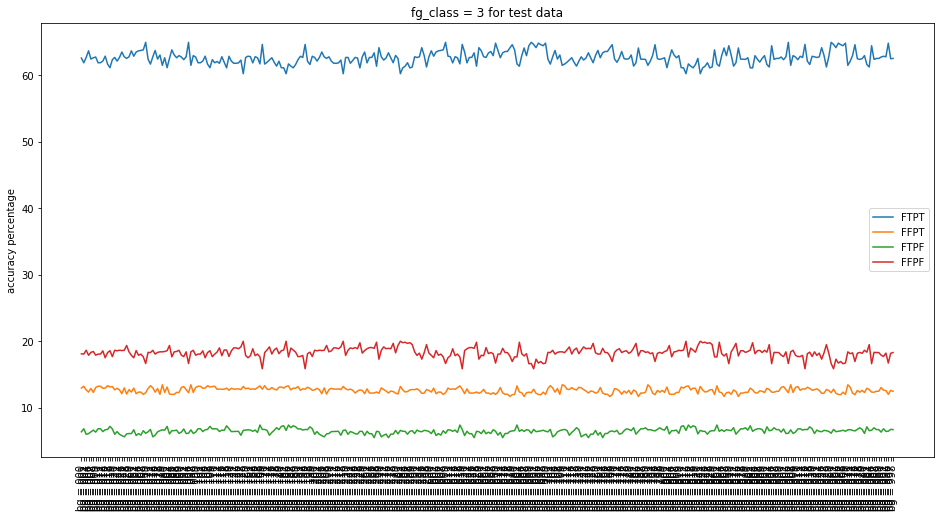

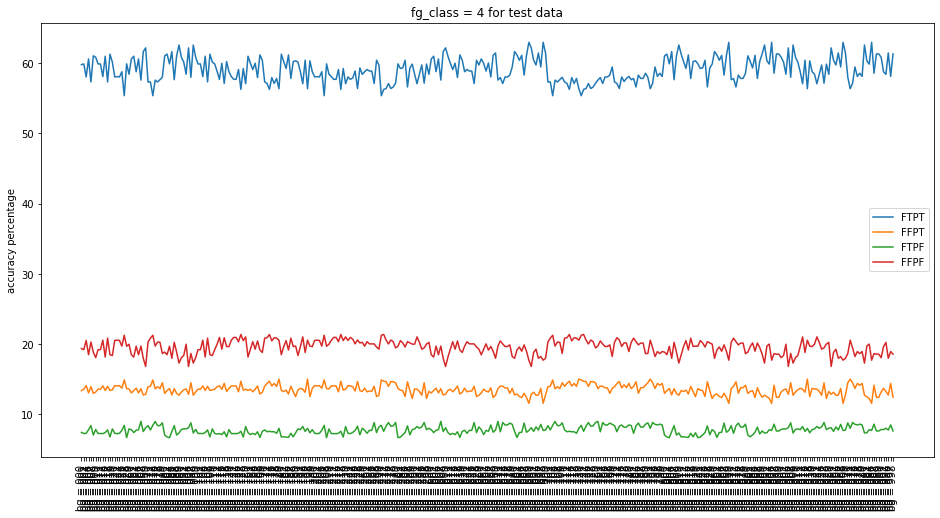

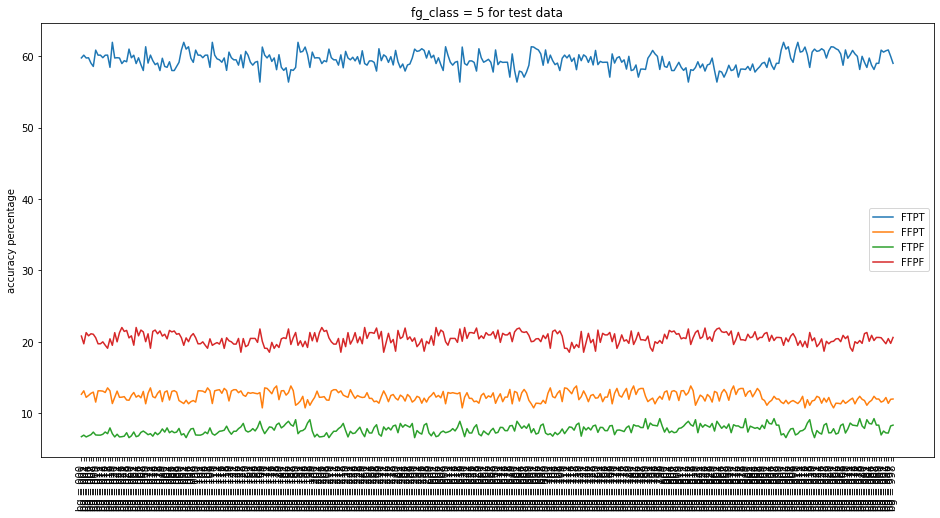

In [68]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt0,label = 'FTPT')
plt.plot(id0, ffpt0 , label = 'FFPT')
plt.plot(id0, ftpf0, label = 'FTPF')
plt.plot(id0, ffpf0, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg1)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg1)+' for test data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt1,label = 'FTPT')
plt.plot(id0, ffpt1 , label = 'FFPT')
plt.plot(id0, ftpf1, label = 'FTPF')
plt.plot(id0, ffpf1, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg2)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg2)+' for test data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt2,label = 'FTPT')
plt.plot(id0, ffpt2 , label = 'FFPT')
plt.plot(id0, ftpf2, label = 'FTPF')
plt.plot(id0, ffpf2, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg3)+' for test data'+".pdf", bbox_inches='tight')

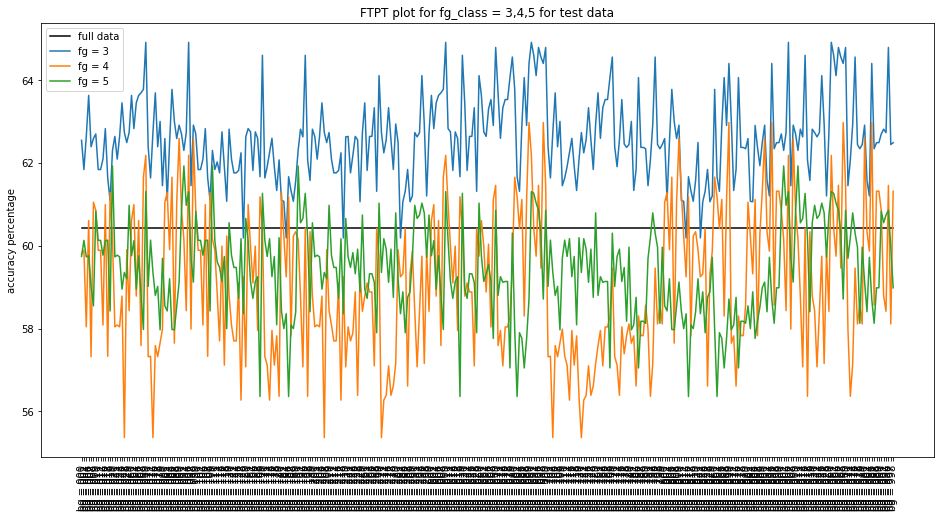

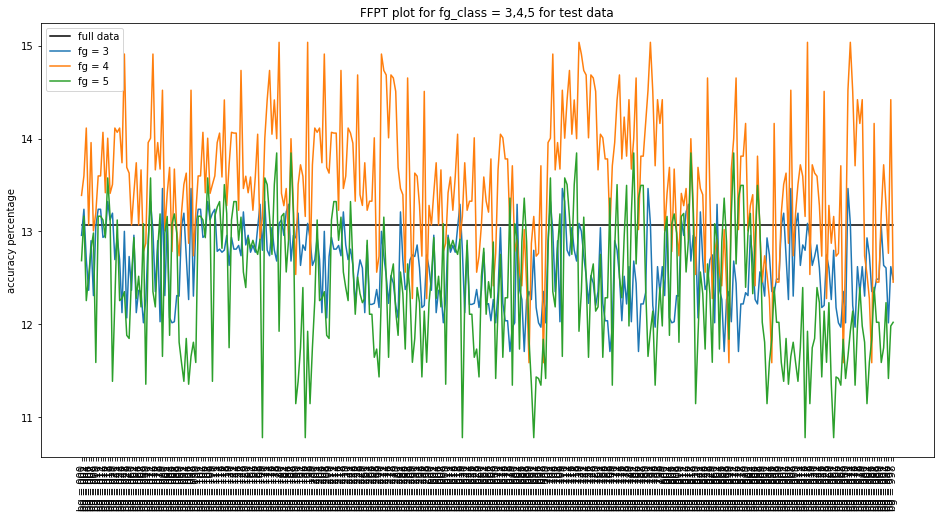

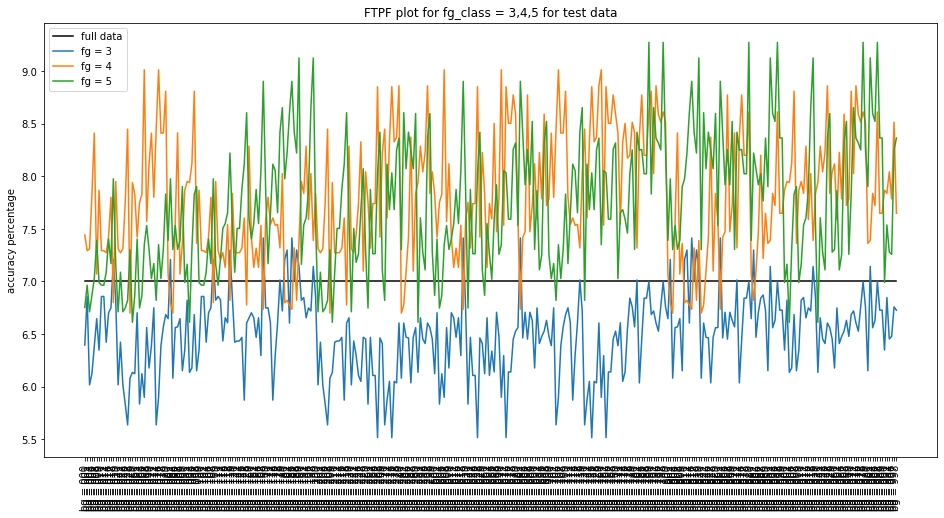

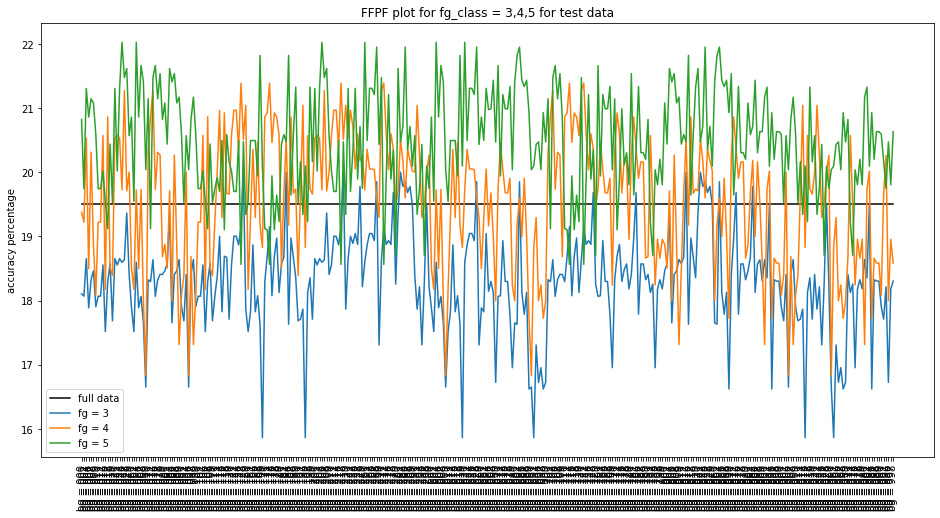

In [69]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpt_full, color='black', label = 'full data')
plt.plot(id0, ftpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpt_full, color='black', label = 'full data')
plt.plot(id0, ffpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpf_full, color='black', label = 'full data')
plt.plot(id0, ftpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpf_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpf_full, color='black', label = 'full data')
plt.plot(id0, ffpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpf_plot.pdf", bbox_inches='tight')